# Vehicle Detection

### William Rifenburgh

---

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

---

The following cells define helper functions for the creating the feature vectors and scanning a camera image with sliding window

In [41]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import pickle
import glob
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [34]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a function to return HOG features and visualization   
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0] * (xy_overlap[0]))
    ny_buffer = np.int(xy_window[1] * (xy_overlap[1]))
    nx_windows = np.int((xspan - nx_buffer) / nx_pix_per_step)
    ny_windows = np.int((yspan - ny_buffer) / ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs * nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys * ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
        cv2.putText(img, 'CAR ' + str(car_number), bbox[0], cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 3)
    # Return the image
    return img

In [3]:
# Read in cars and notcars
cars = glob.glob('./vehicles/*/*.png')
notcars = glob.glob('./non-vehicles/*/*.png')

sample_size = min(len(cars), len(notcars))
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 4  # HOG cells per block
hog_channel = "ALL"  # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off
y_start_stop = [400, 656]  # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space,
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel, spatial_feat=spatial_feat,
                                   hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell,
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t = time.time()

#save params and trained svc to pickle
dist_pickle = {'svc': svc, 'scaler': X_scaler, 'orient': orient, 'pix_per_cell': pix_per_cell,
               'cell_per_block': cell_per_block, 'spatial_size': spatial_size, 'hist_bins': hist_bins}

pickle.dump( dist_pickle, open( "svc_pickle.p", "wb" ) )

/Users/will/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 4 cells per block
Feature vector length: 11664


30.21 Seconds to train SVC...
Test Accuracy of SVC =  0.9881


/Users/will/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


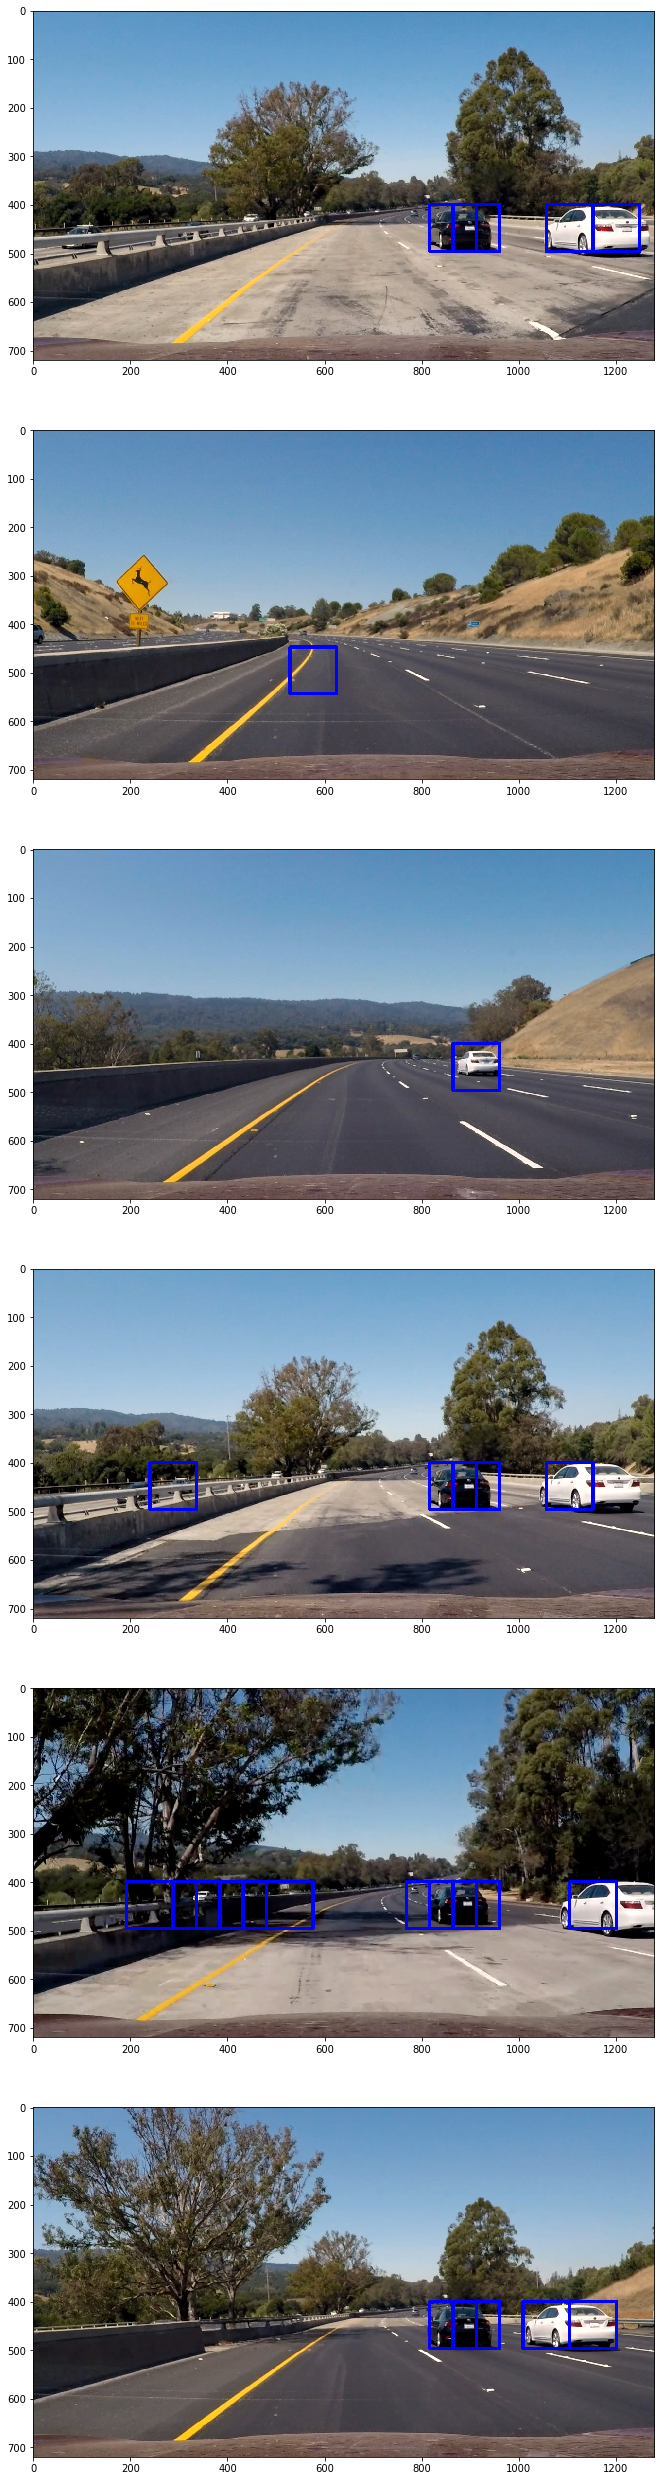

In [4]:
test_images = glob.glob('./test_images/*.jpg')
fig = plt.figure(figsize=(25, 45))

for idx, file in enumerate(test_images):
    image = mpimg.imread(file)
    draw_image = np.copy(image)
    
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,
                           xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_feat=spatial_feat,
                                 hist_feat=hist_feat, hog_feat=hog_feat)

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

    a = fig.add_subplot(len(test_images), 1, idx + 1)
    plt.imshow(window_img)

In [ ]:
# If we like the results, use this cell to save the support vector classifier and relevant parameters
dist_pickle = pickle.load(open("svc_pickle.p", "rb"))
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

/Users/will/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


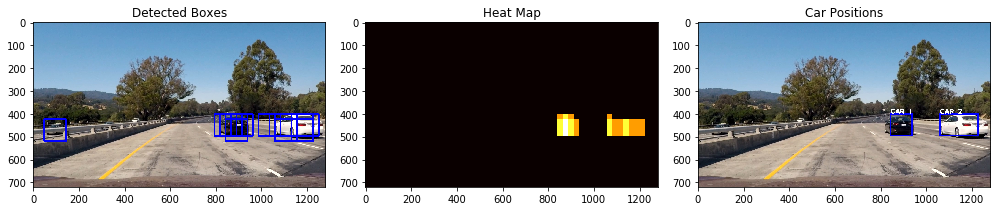

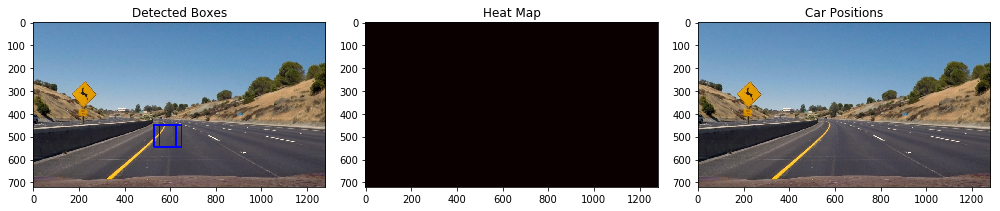

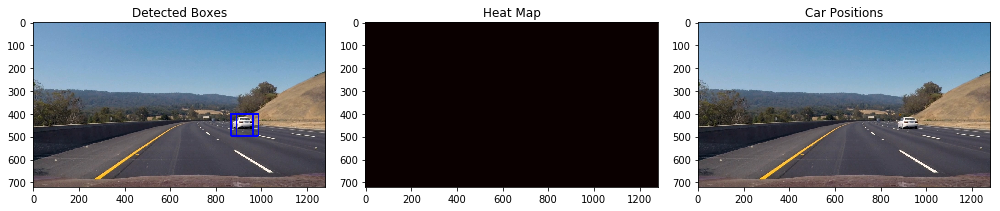

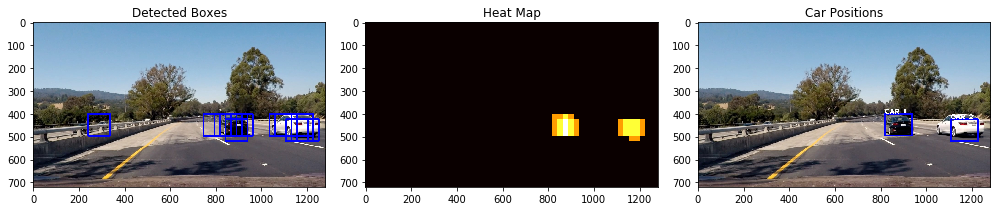

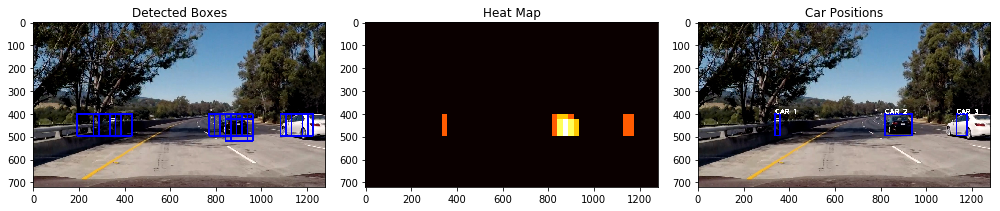

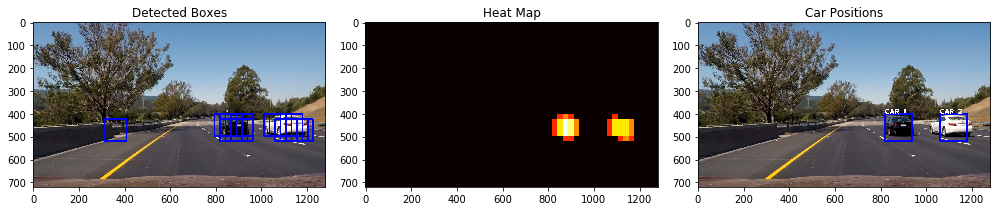

In [38]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32) / 255
    bboxes = []

    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block ** 2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                box = ((xbox_left, ytop_draw + ystart), (xbox_left + win_draw, ytop_draw + win_draw + ystart))
                bboxes.append(box)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                              (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0, 0, 255), 6)

    return draw_img, bboxes

ystart = 400
ystop = 656
scale = 1.5

subplot_num = len(test_images)

for idx, file in enumerate(test_images):
    img = mpimg.imread(file)
    draw_image = np.copy(img)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    # img = draw_image.astype(np.float32)/255

    out_img, bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                                spatial_size,
                                hist_bins)

    # Make the heat map image and use it to create the final bounding boxes
    heat = np.zeros_like(image[:, :, 0]).astype(np.float)
    heat = add_heat(heat, bboxes)
    heat = apply_threshold(heat, 2)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(draw_image, labels)
    
    # Plot final bounding boxes and corresponding heat map image
    fig = plt.figure(figsize=(14, 24))
    fig.add_subplot(subplot_num, 3, 3 * idx + 1)
    plt.imshow(out_img)
    plt.title('Detected Boxes')
    fig.add_subplot(subplot_num, 3, 3 * idx + 2)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.add_subplot(subplot_num, 3, 3 * idx + 3)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    fig.tight_layout()

In [57]:
# Now that our heat maps are shown to threshold well enough, we can integrate our heat maps for our final image processing function
heatmaps = []

def process_frame(frame_img):
    draw_img = np.copy(frame_img)
    out_img, bboxes = find_cars(frame_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                                spatial_size,
                                hist_bins)

    # Make the heat map image and use it to create the final bounding boxes
    heat = np.zeros_like(frame_img[:, :, 0]).astype(np.float)
    heat = add_heat(heat, bboxes)
    heat = apply_threshold(heat, 1)
    
    heatmaps.insert(0, heat)
    
    heat_integrated = np.zeros_like(img[:, :, 0]).astype(np.float)
    for heat_frame in heatmaps:
        heat_integrated = heat_integrated + heat_frame
    
    heat = apply_threshold(heat_integrated, 7)
    
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    
    if len(heatmaps) > 15:
        heatmaps.pop()
    
    return draw_labeled_bboxes(draw_img, labels)

In [58]:
heatmaps = []
video_output = "./output_images/test_output.mp4"
clip1 = VideoFileClip("./test_video.mp4")
clip1_output = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_images/test_output.mp4


[MoviePy] Writing video ./output_images/test_output.mp4


  0%|          | 0/39 [00:00<?, ?it/s]

  3%|▎         | 1/39 [00:00<00:12,  3.06it/s]

  5%|▌         | 2/39 [00:00<00:12,  3.05it/s]

  8%|▊         | 3/39 [00:00<00:11,  3.04it/s]

 10%|█         | 4/39 [00:01<00:11,  3.02it/s]

 13%|█▎        | 5/39 [00:01<00:11,  3.00it/s]

 15%|█▌        | 6/39 [00:02<00:11,  2.99it/s]

 18%|█▊        | 7/39 [00:02<00:10,  2.97it/s]

 21%|██        | 8/39 [00:02<00:10,  2.97it/s]

 23%|██▎       | 9/39 [00:03<00:10,  2.94it/s]

 26%|██▌       | 10/39 [00:03<00:09,  2.92it/s]

 28%|██▊       | 11/39 [00:03<00:09,  2.91it/s]

 31%|███       | 12/39 [00:04<00:09,  2.91it/s]

 33%|███▎      | 13/39 [00:04<00:09,  2.87it/s]

 36%|███▌      | 14/39 [00:04<00:08,  2.87it/s]

 38%|███▊      | 15/39 [00:05<00:08,  2.84it/s]

 41%|████      | 16/39 [00:05<00:08,  2.84it/s]

 44%|████▎     | 17/39 [00:05<00:07,  2.83it/s]

 46%|████▌     | 18/39 [00:06<00:07,  2.82it/s]

 49%|████▊     | 19/39 [00:06<00:07,  2.83it/s]

 51%|█████▏    | 20/39 [00:06<00:06,  2.82it/s]

 54%|█████▍    | 21/39 [00:07<00:06,  2.80it/s]

 56%|█████▋    | 22/39 [00:07<00:06,  2.82it/s]

 59%|█████▉    | 23/39 [00:07<00:05,  2.81it/s]

 62%|██████▏   | 24/39 [00:08<00:05,  2.83it/s]

 64%|██████▍   | 25/39 [00:08<00:04,  2.81it/s]

 67%|██████▋   | 26/39 [00:09<00:04,  2.82it/s]

 69%|██████▉   | 27/39 [00:09<00:04,  2.81it/s]

 72%|███████▏  | 28/39 [00:09<00:03,  2.79it/s]

 74%|███████▍  | 29/39 [00:10<00:03,  2.82it/s]

 77%|███████▋  | 30/39 [00:10<00:03,  2.80it/s]

 79%|███████▉  | 31/39 [00:10<00:02,  2.80it/s]

 82%|████████▏ | 32/39 [00:11<00:02,  2.79it/s]

 85%|████████▍ | 33/39 [00:11<00:02,  2.81it/s]

 87%|████████▋ | 34/39 [00:11<00:01,  2.82it/s]

 90%|████████▉ | 35/39 [00:12<00:01,  2.80it/s]

 92%|█████████▏| 36/39 [00:12<00:01,  2.78it/s]

 95%|█████████▍| 37/39 [00:12<00:00,  2.80it/s]

 97%|█████████▋| 38/39 [00:13<00:00,  2.78it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: ./output_images/test_output.mp4 



CPU times: user 12.3 s, sys: 1.17 s, total: 13.4 s
Wall time: 14 s


In [59]:
heatmaps = []
video_output = "./output_images/project_output.mp4"
clip1 = VideoFileClip("./project_video.mp4")
clip1_output = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_images/project_output.mp4


[MoviePy] Writing video ./output_images/project_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<06:45,  3.11it/s]

  0%|          | 2/1261 [00:00<06:47,  3.09it/s]

  0%|          | 3/1261 [00:00<06:45,  3.10it/s]

  0%|          | 4/1261 [00:01<06:48,  3.08it/s]

  0%|          | 5/1261 [00:01<06:51,  3.05it/s]

  0%|          | 6/1261 [00:01<06:50,  3.06it/s]

  1%|          | 7/1261 [00:02<06:52,  3.04it/s]

  1%|          | 8/1261 [00:02<06:58,  3.00it/s]

  1%|          | 9/1261 [00:02<06:58,  2.99it/s]

  1%|          | 10/1261 [00:03<07:03,  2.96it/s]

  1%|          | 11/1261 [00:03<07:05,  2.94it/s]

  1%|          | 12/1261 [00:04<07:09,  2.91it/s]

  1%|          | 13/1261 [00:04<07:11,  2.89it/s]

  1%|          | 14/1261 [00:04<07:12,  2.88it/s]

  1%|          | 15/1261 [00:05<07:15,  2.86it/s]

  1%|▏         | 16/1261 [00:05<07:20,  2.83it/s]

  1%|▏         | 17/1261 [00:05<07:21,  2.81it/s]

  1%|▏         | 18/1261 [00:06<07:19,  2.83it/s]

  2%|▏         | 19/1261 [00:06<07:16,  2.84it/s]

  2%|▏         | 20/1261 [00:06<07:12,  2.87it/s]

  2%|▏         | 21/1261 [00:07<07:13,  2.86it/s]

  2%|▏         | 22/1261 [00:07<07:11,  2.87it/s]

  2%|▏         | 23/1261 [00:07<07:13,  2.85it/s]

  2%|▏         | 24/1261 [00:08<07:15,  2.84it/s]

  2%|▏         | 25/1261 [00:08<07:15,  2.84it/s]

  2%|▏         | 26/1261 [00:08<07:14,  2.84it/s]

  2%|▏         | 27/1261 [00:09<07:12,  2.85it/s]

  2%|▏         | 28/1261 [00:09<07:12,  2.85it/s]

  2%|▏         | 29/1261 [00:09<07:09,  2.87it/s]

  2%|▏         | 30/1261 [00:10<07:10,  2.86it/s]

  2%|▏         | 31/1261 [00:10<07:11,  2.85it/s]

  3%|▎         | 32/1261 [00:11<07:09,  2.86it/s]

  3%|▎         | 33/1261 [00:11<07:11,  2.85it/s]

  3%|▎         | 34/1261 [00:11<07:12,  2.84it/s]

  3%|▎         | 35/1261 [00:12<07:14,  2.82it/s]

  3%|▎         | 36/1261 [00:12<07:11,  2.84it/s]

  3%|▎         | 37/1261 [00:12<07:12,  2.83it/s]

  3%|▎         | 38/1261 [00:13<07:12,  2.83it/s]

  3%|▎         | 39/1261 [00:13<07:09,  2.85it/s]

  3%|▎         | 40/1261 [00:13<07:06,  2.86it/s]

  3%|▎         | 41/1261 [00:14<07:07,  2.85it/s]

  3%|▎         | 42/1261 [00:14<07:06,  2.86it/s]

  3%|▎         | 43/1261 [00:14<07:06,  2.85it/s]

  3%|▎         | 44/1261 [00:15<07:03,  2.87it/s]

  4%|▎         | 45/1261 [00:15<07:02,  2.88it/s]

  4%|▎         | 46/1261 [00:15<07:01,  2.88it/s]

  4%|▎         | 47/1261 [00:16<07:02,  2.88it/s]

  4%|▍         | 48/1261 [00:16<07:05,  2.85it/s]

  4%|▍         | 49/1261 [00:17<07:05,  2.85it/s]

  4%|▍         | 50/1261 [00:17<07:06,  2.84it/s]

  4%|▍         | 51/1261 [00:17<07:05,  2.84it/s]

  4%|▍         | 52/1261 [00:18<07:02,  2.86it/s]

  4%|▍         | 53/1261 [00:18<06:59,  2.88it/s]

  4%|▍         | 54/1261 [00:18<07:02,  2.86it/s]

  4%|▍         | 55/1261 [00:19<07:02,  2.86it/s]

  4%|▍         | 56/1261 [00:19<06:59,  2.87it/s]

  5%|▍         | 57/1261 [00:19<06:58,  2.88it/s]

  5%|▍         | 58/1261 [00:20<06:58,  2.87it/s]

  5%|▍         | 59/1261 [00:20<07:00,  2.86it/s]

  5%|▍         | 60/1261 [00:20<06:57,  2.88it/s]

  5%|▍         | 61/1261 [00:21<06:53,  2.90it/s]

  5%|▍         | 62/1261 [00:21<06:53,  2.90it/s]

  5%|▍         | 63/1261 [00:21<06:55,  2.88it/s]

  5%|▌         | 64/1261 [00:22<06:54,  2.89it/s]

  5%|▌         | 65/1261 [00:22<06:52,  2.90it/s]

  5%|▌         | 66/1261 [00:22<06:55,  2.88it/s]

  5%|▌         | 67/1261 [00:23<06:53,  2.88it/s]

  5%|▌         | 68/1261 [00:23<06:54,  2.88it/s]

  5%|▌         | 69/1261 [00:23<06:56,  2.87it/s]

  6%|▌         | 70/1261 [00:24<06:56,  2.86it/s]

  6%|▌         | 71/1261 [00:24<06:51,  2.89it/s]

  6%|▌         | 72/1261 [00:25<06:52,  2.88it/s]

  6%|▌         | 73/1261 [00:25<06:51,  2.89it/s]

  6%|▌         | 74/1261 [00:25<06:52,  2.88it/s]

  6%|▌         | 75/1261 [00:26<06:50,  2.89it/s]

  6%|▌         | 76/1261 [00:26<06:49,  2.90it/s]

  6%|▌         | 77/1261 [00:26<06:45,  2.92it/s]

  6%|▌         | 78/1261 [00:27<06:47,  2.90it/s]

  6%|▋         | 79/1261 [00:27<06:49,  2.89it/s]

  6%|▋         | 80/1261 [00:27<06:50,  2.88it/s]

  6%|▋         | 81/1261 [00:28<06:46,  2.90it/s]

  7%|▋         | 82/1261 [00:28<06:50,  2.87it/s]

  7%|▋         | 83/1261 [00:28<06:48,  2.88it/s]

  7%|▋         | 84/1261 [00:29<06:52,  2.85it/s]

  7%|▋         | 85/1261 [00:29<06:51,  2.85it/s]

  7%|▋         | 86/1261 [00:29<06:49,  2.87it/s]

  7%|▋         | 87/1261 [00:30<06:48,  2.88it/s]

  7%|▋         | 88/1261 [00:30<06:47,  2.88it/s]

  7%|▋         | 89/1261 [00:30<06:44,  2.90it/s]

  7%|▋         | 90/1261 [00:31<06:43,  2.90it/s]

  7%|▋         | 91/1261 [00:31<06:43,  2.90it/s]

  7%|▋         | 92/1261 [00:31<06:41,  2.91it/s]

  7%|▋         | 93/1261 [00:32<06:39,  2.92it/s]

  7%|▋         | 94/1261 [00:32<06:42,  2.90it/s]

  8%|▊         | 95/1261 [00:32<06:45,  2.87it/s]

  8%|▊         | 96/1261 [00:33<06:47,  2.86it/s]

  8%|▊         | 97/1261 [00:33<06:47,  2.85it/s]

  8%|▊         | 98/1261 [00:34<06:45,  2.86it/s]

  8%|▊         | 99/1261 [00:34<06:44,  2.88it/s]

  8%|▊         | 100/1261 [00:34<06:46,  2.86it/s]

  8%|▊         | 101/1261 [00:35<06:42,  2.88it/s]

  8%|▊         | 102/1261 [00:35<06:43,  2.88it/s]

  8%|▊         | 103/1261 [00:35<06:41,  2.89it/s]

  8%|▊         | 104/1261 [00:36<06:40,  2.89it/s]

  8%|▊         | 105/1261 [00:36<06:38,  2.90it/s]

  8%|▊         | 106/1261 [00:36<06:39,  2.89it/s]

  8%|▊         | 107/1261 [00:37<06:41,  2.88it/s]

  9%|▊         | 108/1261 [00:37<06:40,  2.88it/s]

  9%|▊         | 109/1261 [00:37<06:38,  2.89it/s]

  9%|▊         | 110/1261 [00:38<06:39,  2.88it/s]

  9%|▉         | 111/1261 [00:38<06:41,  2.87it/s]

  9%|▉         | 112/1261 [00:38<06:38,  2.89it/s]

  9%|▉         | 113/1261 [00:39<06:35,  2.90it/s]

  9%|▉         | 114/1261 [00:39<06:35,  2.90it/s]

  9%|▉         | 115/1261 [00:39<06:33,  2.91it/s]

  9%|▉         | 116/1261 [00:40<06:36,  2.89it/s]

  9%|▉         | 117/1261 [00:40<06:35,  2.90it/s]

  9%|▉         | 118/1261 [00:40<06:36,  2.88it/s]

  9%|▉         | 119/1261 [00:41<06:36,  2.88it/s]

 10%|▉         | 120/1261 [00:41<06:39,  2.85it/s]

 10%|▉         | 121/1261 [00:42<06:40,  2.85it/s]

 10%|▉         | 122/1261 [00:42<06:39,  2.85it/s]

 10%|▉         | 123/1261 [00:42<06:36,  2.87it/s]

 10%|▉         | 124/1261 [00:43<06:35,  2.88it/s]

 10%|▉         | 125/1261 [00:43<06:31,  2.90it/s]

 10%|▉         | 126/1261 [00:43<06:32,  2.89it/s]

 10%|█         | 127/1261 [00:44<06:32,  2.89it/s]

 10%|█         | 128/1261 [00:44<06:36,  2.86it/s]

 10%|█         | 129/1261 [00:44<06:35,  2.86it/s]

 10%|█         | 130/1261 [00:45<06:33,  2.87it/s]

 10%|█         | 131/1261 [00:45<06:35,  2.86it/s]

 10%|█         | 132/1261 [00:45<06:33,  2.87it/s]

 11%|█         | 133/1261 [00:46<06:31,  2.88it/s]

 11%|█         | 134/1261 [00:46<06:27,  2.91it/s]

 11%|█         | 135/1261 [00:46<06:29,  2.89it/s]

 11%|█         | 136/1261 [00:47<06:31,  2.88it/s]

 11%|█         | 137/1261 [00:47<06:26,  2.91it/s]

 11%|█         | 138/1261 [00:47<06:27,  2.90it/s]

 11%|█         | 139/1261 [00:48<06:29,  2.88it/s]

 11%|█         | 140/1261 [00:48<06:29,  2.88it/s]

 11%|█         | 141/1261 [00:48<06:30,  2.86it/s]

 11%|█▏        | 142/1261 [00:49<06:28,  2.88it/s]

 11%|█▏        | 143/1261 [00:49<06:26,  2.89it/s]

 11%|█▏        | 144/1261 [00:49<06:27,  2.88it/s]

 11%|█▏        | 145/1261 [00:50<06:27,  2.88it/s]

 12%|█▏        | 146/1261 [00:50<06:25,  2.89it/s]

 12%|█▏        | 147/1261 [00:51<06:26,  2.88it/s]

 12%|█▏        | 148/1261 [00:51<06:23,  2.90it/s]

 12%|█▏        | 149/1261 [00:51<06:28,  2.86it/s]

 12%|█▏        | 150/1261 [00:52<06:33,  2.82it/s]

 12%|█▏        | 151/1261 [00:52<06:28,  2.86it/s]

 12%|█▏        | 152/1261 [00:52<06:29,  2.84it/s]

 12%|█▏        | 153/1261 [00:53<06:28,  2.85it/s]

 12%|█▏        | 154/1261 [00:53<06:25,  2.87it/s]

 12%|█▏        | 155/1261 [00:53<06:25,  2.87it/s]

 12%|█▏        | 156/1261 [00:54<06:24,  2.87it/s]

 12%|█▏        | 157/1261 [00:54<06:22,  2.89it/s]

 13%|█▎        | 158/1261 [00:54<06:19,  2.90it/s]

 13%|█▎        | 159/1261 [00:55<06:20,  2.89it/s]

 13%|█▎        | 160/1261 [00:55<06:22,  2.88it/s]

 13%|█▎        | 161/1261 [00:55<06:22,  2.87it/s]

 13%|█▎        | 162/1261 [00:56<06:23,  2.86it/s]

 13%|█▎        | 163/1261 [00:56<06:21,  2.88it/s]

 13%|█▎        | 164/1261 [00:56<06:19,  2.89it/s]

 13%|█▎        | 165/1261 [00:57<06:19,  2.88it/s]

 13%|█▎        | 166/1261 [00:57<06:20,  2.87it/s]

 13%|█▎        | 167/1261 [00:57<06:20,  2.88it/s]

 13%|█▎        | 168/1261 [00:58<06:22,  2.86it/s]

 13%|█▎        | 169/1261 [00:58<06:21,  2.86it/s]

 13%|█▎        | 170/1261 [00:59<06:21,  2.86it/s]

 14%|█▎        | 171/1261 [00:59<06:19,  2.87it/s]

 14%|█▎        | 172/1261 [00:59<06:20,  2.86it/s]

 14%|█▎        | 173/1261 [01:00<06:20,  2.86it/s]

 14%|█▍        | 174/1261 [01:00<06:22,  2.84it/s]

 14%|█▍        | 175/1261 [01:00<06:22,  2.84it/s]

 14%|█▍        | 176/1261 [01:01<06:22,  2.84it/s]

 14%|█▍        | 177/1261 [01:01<06:21,  2.84it/s]

 14%|█▍        | 178/1261 [01:01<06:21,  2.84it/s]

 14%|█▍        | 179/1261 [01:02<06:19,  2.85it/s]

 14%|█▍        | 180/1261 [01:02<06:19,  2.85it/s]

 14%|█▍        | 181/1261 [01:02<06:19,  2.84it/s]

 14%|█▍        | 182/1261 [01:03<06:16,  2.86it/s]

 15%|█▍        | 183/1261 [01:03<06:20,  2.83it/s]

 15%|█▍        | 184/1261 [01:03<06:17,  2.85it/s]

 15%|█▍        | 185/1261 [01:04<06:17,  2.85it/s]

 15%|█▍        | 186/1261 [01:04<06:14,  2.87it/s]

 15%|█▍        | 187/1261 [01:05<06:16,  2.85it/s]

 15%|█▍        | 188/1261 [01:05<06:12,  2.88it/s]

 15%|█▍        | 189/1261 [01:05<06:09,  2.90it/s]

 15%|█▌        | 190/1261 [01:06<06:11,  2.88it/s]

 15%|█▌        | 191/1261 [01:06<06:11,  2.88it/s]

 15%|█▌        | 192/1261 [01:06<06:13,  2.86it/s]

 15%|█▌        | 193/1261 [01:07<06:11,  2.87it/s]

 15%|█▌        | 194/1261 [01:07<06:12,  2.87it/s]

 15%|█▌        | 195/1261 [01:07<06:10,  2.87it/s]

 16%|█▌        | 196/1261 [01:08<06:10,  2.87it/s]

 16%|█▌        | 197/1261 [01:08<06:09,  2.88it/s]

 16%|█▌        | 198/1261 [01:08<06:10,  2.87it/s]

 16%|█▌        | 199/1261 [01:09<06:08,  2.88it/s]

 16%|█▌        | 200/1261 [01:09<06:12,  2.85it/s]

 16%|█▌        | 201/1261 [01:09<06:11,  2.86it/s]

 16%|█▌        | 202/1261 [01:10<06:13,  2.84it/s]

 16%|█▌        | 203/1261 [01:10<06:11,  2.85it/s]

 16%|█▌        | 204/1261 [01:10<06:10,  2.85it/s]

 16%|█▋        | 205/1261 [01:11<06:08,  2.86it/s]

 16%|█▋        | 206/1261 [01:11<06:13,  2.82it/s]

 16%|█▋        | 207/1261 [01:12<06:13,  2.82it/s]

 16%|█▋        | 208/1261 [01:12<06:14,  2.81it/s]

 17%|█▋        | 209/1261 [01:12<06:13,  2.82it/s]

 17%|█▋        | 210/1261 [01:13<06:12,  2.82it/s]

 17%|█▋        | 211/1261 [01:13<06:11,  2.83it/s]

 17%|█▋        | 212/1261 [01:13<06:06,  2.86it/s]

 17%|█▋        | 213/1261 [01:14<06:08,  2.84it/s]

 17%|█▋        | 214/1261 [01:14<06:05,  2.87it/s]

 17%|█▋        | 215/1261 [01:14<06:04,  2.87it/s]

 17%|█▋        | 216/1261 [01:15<06:03,  2.87it/s]

 17%|█▋        | 217/1261 [01:15<06:05,  2.85it/s]

 17%|█▋        | 218/1261 [01:15<06:05,  2.86it/s]

 17%|█▋        | 219/1261 [01:16<06:05,  2.85it/s]

 17%|█▋        | 220/1261 [01:16<06:06,  2.84it/s]

 18%|█▊        | 221/1261 [01:16<06:05,  2.84it/s]

 18%|█▊        | 222/1261 [01:17<06:07,  2.83it/s]

 18%|█▊        | 223/1261 [01:17<06:03,  2.86it/s]

 18%|█▊        | 224/1261 [01:17<06:05,  2.83it/s]

 18%|█▊        | 225/1261 [01:18<06:05,  2.84it/s]

 18%|█▊        | 226/1261 [01:18<06:05,  2.83it/s]

 18%|█▊        | 227/1261 [01:19<06:02,  2.85it/s]

 18%|█▊        | 228/1261 [01:19<06:01,  2.85it/s]

 18%|█▊        | 229/1261 [01:19<06:00,  2.86it/s]

 18%|█▊        | 230/1261 [01:20<06:00,  2.86it/s]

 18%|█▊        | 231/1261 [01:20<06:01,  2.85it/s]

 18%|█▊        | 232/1261 [01:20<05:59,  2.86it/s]

 18%|█▊        | 233/1261 [01:21<06:00,  2.85it/s]

 19%|█▊        | 234/1261 [01:21<06:00,  2.85it/s]

 19%|█▊        | 235/1261 [01:21<06:01,  2.84it/s]

 19%|█▊        | 236/1261 [01:22<06:00,  2.84it/s]

 19%|█▉        | 237/1261 [01:22<05:57,  2.86it/s]

 19%|█▉        | 238/1261 [01:22<05:59,  2.84it/s]

 19%|█▉        | 239/1261 [01:23<05:56,  2.87it/s]

 19%|█▉        | 240/1261 [01:23<05:55,  2.87it/s]

 19%|█▉        | 241/1261 [01:23<05:57,  2.85it/s]

 19%|█▉        | 242/1261 [01:24<05:58,  2.84it/s]

 19%|█▉        | 243/1261 [01:24<05:58,  2.84it/s]

 19%|█▉        | 244/1261 [01:24<05:58,  2.83it/s]

 19%|█▉        | 245/1261 [01:25<05:59,  2.82it/s]

 20%|█▉        | 246/1261 [01:25<05:57,  2.84it/s]

 20%|█▉        | 247/1261 [01:26<05:57,  2.84it/s]

 20%|█▉        | 248/1261 [01:26<05:56,  2.84it/s]

 20%|█▉        | 249/1261 [01:26<05:51,  2.88it/s]

 20%|█▉        | 250/1261 [01:27<05:49,  2.89it/s]

 20%|█▉        | 251/1261 [01:27<05:47,  2.91it/s]

 20%|█▉        | 252/1261 [01:27<05:47,  2.90it/s]

 20%|██        | 253/1261 [01:28<05:48,  2.89it/s]

 20%|██        | 254/1261 [01:28<05:50,  2.87it/s]

 20%|██        | 255/1261 [01:28<05:47,  2.90it/s]

 20%|██        | 256/1261 [01:29<05:48,  2.88it/s]

 20%|██        | 257/1261 [01:29<05:48,  2.88it/s]

 20%|██        | 258/1261 [01:29<05:49,  2.87it/s]

 21%|██        | 259/1261 [01:30<05:49,  2.87it/s]

 21%|██        | 260/1261 [01:30<05:50,  2.85it/s]

 21%|██        | 261/1261 [01:30<05:50,  2.86it/s]

 21%|██        | 262/1261 [01:31<05:48,  2.87it/s]

 21%|██        | 263/1261 [01:31<05:47,  2.88it/s]

 21%|██        | 264/1261 [01:31<05:51,  2.83it/s]

 21%|██        | 265/1261 [01:32<05:51,  2.84it/s]

 21%|██        | 266/1261 [01:32<05:50,  2.84it/s]

 21%|██        | 267/1261 [01:33<05:52,  2.82it/s]

 21%|██▏       | 268/1261 [01:33<05:50,  2.83it/s]

 21%|██▏       | 269/1261 [01:33<05:51,  2.82it/s]

 21%|██▏       | 270/1261 [01:34<05:50,  2.83it/s]

 21%|██▏       | 271/1261 [01:34<05:49,  2.83it/s]

 22%|██▏       | 272/1261 [01:34<05:47,  2.85it/s]

 22%|██▏       | 273/1261 [01:35<05:45,  2.86it/s]

 22%|██▏       | 274/1261 [01:35<05:46,  2.85it/s]

 22%|██▏       | 275/1261 [01:35<05:44,  2.86it/s]

 22%|██▏       | 276/1261 [01:36<05:45,  2.85it/s]

 22%|██▏       | 277/1261 [01:36<05:43,  2.86it/s]

 22%|██▏       | 278/1261 [01:36<05:43,  2.86it/s]

 22%|██▏       | 279/1261 [01:37<05:42,  2.86it/s]

 22%|██▏       | 280/1261 [01:37<05:40,  2.89it/s]

 22%|██▏       | 281/1261 [01:37<05:40,  2.88it/s]

 22%|██▏       | 282/1261 [01:38<05:42,  2.86it/s]

 22%|██▏       | 283/1261 [01:38<05:42,  2.85it/s]

 23%|██▎       | 284/1261 [01:38<05:40,  2.87it/s]

 23%|██▎       | 285/1261 [01:39<05:39,  2.88it/s]

 23%|██▎       | 286/1261 [01:39<05:39,  2.87it/s]

 23%|██▎       | 287/1261 [01:40<05:42,  2.85it/s]

 23%|██▎       | 288/1261 [01:40<05:44,  2.82it/s]

 23%|██▎       | 289/1261 [01:40<05:49,  2.78it/s]

 23%|██▎       | 290/1261 [01:41<05:44,  2.82it/s]

 23%|██▎       | 291/1261 [01:41<05:42,  2.83it/s]

 23%|██▎       | 292/1261 [01:41<05:39,  2.85it/s]

 23%|██▎       | 293/1261 [01:42<05:37,  2.87it/s]

 23%|██▎       | 294/1261 [01:42<05:36,  2.87it/s]

 23%|██▎       | 295/1261 [01:42<05:36,  2.87it/s]

 23%|██▎       | 296/1261 [01:43<05:37,  2.86it/s]

 24%|██▎       | 297/1261 [01:43<05:40,  2.83it/s]

 24%|██▎       | 298/1261 [01:43<05:36,  2.86it/s]

 24%|██▎       | 299/1261 [01:44<05:37,  2.85it/s]

 24%|██▍       | 300/1261 [01:44<05:38,  2.84it/s]

 24%|██▍       | 301/1261 [01:44<05:37,  2.85it/s]

 24%|██▍       | 302/1261 [01:45<05:36,  2.85it/s]

 24%|██▍       | 303/1261 [01:45<05:36,  2.85it/s]

 24%|██▍       | 304/1261 [01:46<05:35,  2.85it/s]

 24%|██▍       | 305/1261 [01:46<05:32,  2.88it/s]

 24%|██▍       | 306/1261 [01:46<05:35,  2.84it/s]

 24%|██▍       | 307/1261 [01:47<05:35,  2.85it/s]

 24%|██▍       | 308/1261 [01:47<05:36,  2.84it/s]

 25%|██▍       | 309/1261 [01:47<05:35,  2.84it/s]

 25%|██▍       | 310/1261 [01:48<05:35,  2.84it/s]

 25%|██▍       | 311/1261 [01:48<05:35,  2.84it/s]

 25%|██▍       | 312/1261 [01:48<05:34,  2.83it/s]

 25%|██▍       | 313/1261 [01:49<05:34,  2.84it/s]

 25%|██▍       | 314/1261 [01:49<05:31,  2.86it/s]

 25%|██▍       | 315/1261 [01:49<05:28,  2.88it/s]

 25%|██▌       | 316/1261 [01:50<05:30,  2.86it/s]

 25%|██▌       | 317/1261 [01:50<05:29,  2.86it/s]

 25%|██▌       | 318/1261 [01:50<05:28,  2.87it/s]

 25%|██▌       | 319/1261 [01:51<05:26,  2.88it/s]

 25%|██▌       | 320/1261 [01:51<05:24,  2.90it/s]

 25%|██▌       | 321/1261 [01:51<05:24,  2.90it/s]

 26%|██▌       | 322/1261 [01:52<05:27,  2.87it/s]

 26%|██▌       | 323/1261 [01:52<05:27,  2.86it/s]

 26%|██▌       | 324/1261 [01:52<05:27,  2.86it/s]

 26%|██▌       | 325/1261 [01:53<05:25,  2.88it/s]

 26%|██▌       | 326/1261 [01:53<05:27,  2.86it/s]

 26%|██▌       | 327/1261 [01:54<05:27,  2.85it/s]

 26%|██▌       | 328/1261 [01:54<05:25,  2.86it/s]

 26%|██▌       | 329/1261 [01:54<05:24,  2.87it/s]

 26%|██▌       | 330/1261 [01:55<05:28,  2.84it/s]

 26%|██▌       | 331/1261 [01:55<05:25,  2.86it/s]

 26%|██▋       | 332/1261 [01:55<05:25,  2.86it/s]

 26%|██▋       | 333/1261 [01:56<05:25,  2.85it/s]

 26%|██▋       | 334/1261 [01:56<05:25,  2.85it/s]

 27%|██▋       | 335/1261 [01:56<05:23,  2.86it/s]

 27%|██▋       | 336/1261 [01:57<05:25,  2.84it/s]

 27%|██▋       | 337/1261 [01:57<05:27,  2.82it/s]

 27%|██▋       | 338/1261 [01:57<05:24,  2.84it/s]

 27%|██▋       | 339/1261 [01:58<05:25,  2.84it/s]

 27%|██▋       | 340/1261 [01:58<05:24,  2.84it/s]

 27%|██▋       | 341/1261 [01:58<05:21,  2.86it/s]

 27%|██▋       | 342/1261 [01:59<05:22,  2.85it/s]

 27%|██▋       | 343/1261 [01:59<05:21,  2.85it/s]

 27%|██▋       | 344/1261 [02:00<05:18,  2.88it/s]

 27%|██▋       | 345/1261 [02:00<05:20,  2.86it/s]

 27%|██▋       | 346/1261 [02:00<05:16,  2.90it/s]

 28%|██▊       | 347/1261 [02:01<05:19,  2.86it/s]

 28%|██▊       | 348/1261 [02:01<05:19,  2.86it/s]

 28%|██▊       | 349/1261 [02:01<05:21,  2.83it/s]

 28%|██▊       | 350/1261 [02:02<05:20,  2.85it/s]

 28%|██▊       | 351/1261 [02:02<05:17,  2.86it/s]

 28%|██▊       | 352/1261 [02:02<05:16,  2.87it/s]

 28%|██▊       | 353/1261 [02:03<05:16,  2.87it/s]

 28%|██▊       | 354/1261 [02:03<05:19,  2.84it/s]

 28%|██▊       | 355/1261 [02:03<05:17,  2.85it/s]

 28%|██▊       | 356/1261 [02:04<05:16,  2.86it/s]

 28%|██▊       | 357/1261 [02:04<05:14,  2.88it/s]

 28%|██▊       | 358/1261 [02:04<05:13,  2.88it/s]

 28%|██▊       | 359/1261 [02:05<05:14,  2.86it/s]

 29%|██▊       | 360/1261 [02:05<05:15,  2.86it/s]

 29%|██▊       | 361/1261 [02:05<05:20,  2.81it/s]

 29%|██▊       | 362/1261 [02:06<05:22,  2.79it/s]

 29%|██▉       | 363/1261 [02:06<05:24,  2.77it/s]

 29%|██▉       | 364/1261 [02:07<05:20,  2.80it/s]

 29%|██▉       | 365/1261 [02:07<05:16,  2.83it/s]

 29%|██▉       | 366/1261 [02:07<05:17,  2.82it/s]

 29%|██▉       | 367/1261 [02:08<05:14,  2.85it/s]

 29%|██▉       | 368/1261 [02:08<05:13,  2.85it/s]

 29%|██▉       | 369/1261 [02:08<05:14,  2.83it/s]

 29%|██▉       | 370/1261 [02:09<05:12,  2.85it/s]

 29%|██▉       | 371/1261 [02:09<05:13,  2.84it/s]

 30%|██▉       | 372/1261 [02:09<05:12,  2.85it/s]

 30%|██▉       | 373/1261 [02:10<05:15,  2.81it/s]

 30%|██▉       | 374/1261 [02:10<05:16,  2.81it/s]

 30%|██▉       | 375/1261 [02:10<05:15,  2.81it/s]

 30%|██▉       | 376/1261 [02:11<05:13,  2.82it/s]

 30%|██▉       | 377/1261 [02:11<05:12,  2.83it/s]

 30%|██▉       | 378/1261 [02:11<05:11,  2.83it/s]

 30%|███       | 379/1261 [02:12<05:11,  2.83it/s]

 30%|███       | 380/1261 [02:12<05:09,  2.85it/s]

 30%|███       | 381/1261 [02:13<05:10,  2.83it/s]

 30%|███       | 382/1261 [02:13<05:07,  2.86it/s]

 30%|███       | 383/1261 [02:13<05:04,  2.89it/s]

 30%|███       | 384/1261 [02:14<05:03,  2.89it/s]

 31%|███       | 385/1261 [02:14<05:03,  2.89it/s]

 31%|███       | 386/1261 [02:14<05:05,  2.87it/s]

 31%|███       | 387/1261 [02:15<05:05,  2.86it/s]

 31%|███       | 388/1261 [02:15<05:05,  2.86it/s]

 31%|███       | 389/1261 [02:15<05:04,  2.87it/s]

 31%|███       | 390/1261 [02:16<05:02,  2.88it/s]

 31%|███       | 391/1261 [02:16<04:59,  2.90it/s]

 31%|███       | 392/1261 [02:16<05:01,  2.88it/s]

 31%|███       | 393/1261 [02:17<05:04,  2.85it/s]

 31%|███       | 394/1261 [02:17<05:08,  2.81it/s]

 31%|███▏      | 395/1261 [02:17<05:11,  2.78it/s]

 31%|███▏      | 396/1261 [02:18<05:06,  2.82it/s]

 31%|███▏      | 397/1261 [02:18<05:04,  2.83it/s]

 32%|███▏      | 398/1261 [02:18<05:03,  2.84it/s]

 32%|███▏      | 399/1261 [02:19<05:03,  2.84it/s]

 32%|███▏      | 400/1261 [02:19<05:02,  2.84it/s]

 32%|███▏      | 401/1261 [02:20<05:02,  2.84it/s]

 32%|███▏      | 402/1261 [02:20<05:02,  2.84it/s]

 32%|███▏      | 403/1261 [02:20<05:01,  2.84it/s]

 32%|███▏      | 404/1261 [02:21<05:01,  2.84it/s]

 32%|███▏      | 405/1261 [02:21<05:00,  2.85it/s]

 32%|███▏      | 406/1261 [02:21<04:57,  2.87it/s]

 32%|███▏      | 407/1261 [02:22<04:57,  2.87it/s]

 32%|███▏      | 408/1261 [02:22<04:58,  2.86it/s]

 32%|███▏      | 409/1261 [02:22<04:57,  2.86it/s]

 33%|███▎      | 410/1261 [02:23<04:58,  2.85it/s]

 33%|███▎      | 411/1261 [02:23<04:59,  2.84it/s]

 33%|███▎      | 412/1261 [02:23<05:00,  2.82it/s]

 33%|███▎      | 413/1261 [02:24<05:00,  2.82it/s]

 33%|███▎      | 414/1261 [02:24<05:00,  2.82it/s]

 33%|███▎      | 415/1261 [02:24<04:57,  2.84it/s]

 33%|███▎      | 416/1261 [02:25<04:58,  2.83it/s]

 33%|███▎      | 417/1261 [02:25<04:54,  2.86it/s]

 33%|███▎      | 418/1261 [02:26<04:53,  2.87it/s]

 33%|███▎      | 419/1261 [02:26<04:54,  2.86it/s]

 33%|███▎      | 420/1261 [02:26<04:54,  2.86it/s]

 33%|███▎      | 421/1261 [02:27<04:53,  2.86it/s]

 33%|███▎      | 422/1261 [02:27<04:54,  2.85it/s]

 34%|███▎      | 423/1261 [02:27<04:53,  2.85it/s]

 34%|███▎      | 424/1261 [02:28<04:51,  2.87it/s]

 34%|███▎      | 425/1261 [02:28<04:52,  2.86it/s]

 34%|███▍      | 426/1261 [02:28<04:52,  2.86it/s]

 34%|███▍      | 427/1261 [02:29<04:52,  2.85it/s]

 34%|███▍      | 428/1261 [02:29<04:52,  2.85it/s]

 34%|███▍      | 429/1261 [02:29<04:52,  2.84it/s]

 34%|███▍      | 430/1261 [02:30<04:52,  2.84it/s]

 34%|███▍      | 431/1261 [02:30<04:51,  2.85it/s]

 34%|███▍      | 432/1261 [02:30<04:52,  2.83it/s]

 34%|███▍      | 433/1261 [02:31<04:51,  2.84it/s]

 34%|███▍      | 434/1261 [02:31<04:51,  2.84it/s]

 34%|███▍      | 435/1261 [02:31<04:49,  2.86it/s]

 35%|███▍      | 436/1261 [02:32<04:48,  2.86it/s]

 35%|███▍      | 437/1261 [02:32<04:45,  2.88it/s]

 35%|███▍      | 438/1261 [02:33<04:47,  2.86it/s]

 35%|███▍      | 439/1261 [02:33<04:47,  2.85it/s]

 35%|███▍      | 440/1261 [02:33<04:45,  2.88it/s]

 35%|███▍      | 441/1261 [02:34<04:47,  2.85it/s]

 35%|███▌      | 442/1261 [02:34<04:46,  2.85it/s]

 35%|███▌      | 443/1261 [02:34<04:45,  2.87it/s]

 35%|███▌      | 444/1261 [02:35<04:46,  2.86it/s]

 35%|███▌      | 445/1261 [02:35<04:45,  2.86it/s]

 35%|███▌      | 446/1261 [02:35<04:45,  2.86it/s]

 35%|███▌      | 447/1261 [02:36<04:44,  2.86it/s]

 36%|███▌      | 448/1261 [02:36<04:43,  2.86it/s]

 36%|███▌      | 449/1261 [02:36<04:45,  2.84it/s]

 36%|███▌      | 450/1261 [02:37<04:44,  2.85it/s]

 36%|███▌      | 451/1261 [02:37<04:45,  2.84it/s]

 36%|███▌      | 452/1261 [02:37<04:44,  2.84it/s]

 36%|███▌      | 453/1261 [02:38<04:44,  2.84it/s]

 36%|███▌      | 454/1261 [02:38<04:42,  2.86it/s]

 36%|███▌      | 455/1261 [02:38<04:41,  2.87it/s]

 36%|███▌      | 456/1261 [02:39<04:43,  2.84it/s]

 36%|███▌      | 457/1261 [02:39<04:41,  2.85it/s]

 36%|███▋      | 458/1261 [02:40<04:44,  2.82it/s]

 36%|███▋      | 459/1261 [02:40<04:45,  2.81it/s]

 36%|███▋      | 460/1261 [02:40<04:43,  2.82it/s]

 37%|███▋      | 461/1261 [02:41<04:43,  2.82it/s]

 37%|███▋      | 462/1261 [02:41<04:40,  2.85it/s]

 37%|███▋      | 463/1261 [02:41<04:40,  2.84it/s]

 37%|███▋      | 464/1261 [02:42<04:38,  2.86it/s]

 37%|███▋      | 465/1261 [02:42<04:38,  2.86it/s]

 37%|███▋      | 466/1261 [02:42<04:37,  2.86it/s]

 37%|███▋      | 467/1261 [02:43<04:36,  2.87it/s]

 37%|███▋      | 468/1261 [02:43<04:36,  2.87it/s]

 37%|███▋      | 469/1261 [02:43<04:35,  2.87it/s]

 37%|███▋      | 470/1261 [02:44<04:34,  2.89it/s]

 37%|███▋      | 471/1261 [02:44<04:33,  2.89it/s]

 37%|███▋      | 472/1261 [02:44<04:34,  2.88it/s]

 38%|███▊      | 473/1261 [02:45<04:33,  2.88it/s]

 38%|███▊      | 474/1261 [02:45<04:34,  2.87it/s]

 38%|███▊      | 475/1261 [02:45<04:35,  2.86it/s]

 38%|███▊      | 476/1261 [02:46<04:32,  2.88it/s]

 38%|███▊      | 477/1261 [02:46<04:32,  2.88it/s]

 38%|███▊      | 478/1261 [02:47<04:30,  2.90it/s]

 38%|███▊      | 479/1261 [02:47<04:32,  2.87it/s]

 38%|███▊      | 480/1261 [02:47<04:30,  2.89it/s]

 38%|███▊      | 481/1261 [02:48<04:30,  2.89it/s]

 38%|███▊      | 482/1261 [02:48<04:31,  2.87it/s]

 38%|███▊      | 483/1261 [02:48<04:32,  2.86it/s]

 38%|███▊      | 484/1261 [02:49<04:30,  2.87it/s]

 38%|███▊      | 485/1261 [02:49<04:33,  2.84it/s]

 39%|███▊      | 486/1261 [02:49<04:32,  2.85it/s]

 39%|███▊      | 487/1261 [02:50<04:32,  2.84it/s]

 39%|███▊      | 488/1261 [02:50<04:30,  2.86it/s]

 39%|███▉      | 489/1261 [02:50<04:30,  2.85it/s]

 39%|███▉      | 490/1261 [02:51<04:28,  2.87it/s]

 39%|███▉      | 491/1261 [02:51<04:31,  2.84it/s]

 39%|███▉      | 492/1261 [02:51<04:30,  2.84it/s]

 39%|███▉      | 493/1261 [02:52<04:29,  2.85it/s]

 39%|███▉      | 494/1261 [02:52<04:29,  2.85it/s]

 39%|███▉      | 495/1261 [02:52<04:30,  2.84it/s]

 39%|███▉      | 496/1261 [02:53<04:28,  2.85it/s]

 39%|███▉      | 497/1261 [02:53<04:26,  2.87it/s]

 39%|███▉      | 498/1261 [02:54<04:26,  2.86it/s]

 40%|███▉      | 499/1261 [02:54<04:26,  2.86it/s]

 40%|███▉      | 500/1261 [02:54<04:27,  2.84it/s]

 40%|███▉      | 501/1261 [02:55<04:25,  2.86it/s]

 40%|███▉      | 502/1261 [02:55<04:23,  2.88it/s]

 40%|███▉      | 503/1261 [02:55<04:23,  2.87it/s]

 40%|███▉      | 504/1261 [02:56<04:25,  2.85it/s]

 40%|████      | 505/1261 [02:56<04:25,  2.85it/s]

 40%|████      | 506/1261 [02:56<04:25,  2.84it/s]

 40%|████      | 507/1261 [02:57<04:25,  2.84it/s]

 40%|████      | 508/1261 [02:57<04:24,  2.85it/s]

 40%|████      | 509/1261 [02:57<04:24,  2.84it/s]

 40%|████      | 510/1261 [02:58<04:23,  2.85it/s]

 41%|████      | 511/1261 [02:58<04:23,  2.85it/s]

 41%|████      | 512/1261 [02:58<04:22,  2.85it/s]

 41%|████      | 513/1261 [02:59<04:21,  2.85it/s]

 41%|████      | 514/1261 [02:59<04:21,  2.86it/s]

 41%|████      | 515/1261 [02:59<04:19,  2.87it/s]

 41%|████      | 516/1261 [03:00<04:19,  2.87it/s]

 41%|████      | 517/1261 [03:00<04:18,  2.87it/s]

 41%|████      | 518/1261 [03:01<04:19,  2.86it/s]

 41%|████      | 519/1261 [03:01<04:18,  2.87it/s]

 41%|████      | 520/1261 [03:01<04:19,  2.85it/s]

 41%|████▏     | 521/1261 [03:02<04:21,  2.83it/s]

 41%|████▏     | 522/1261 [03:02<04:22,  2.82it/s]

 41%|████▏     | 523/1261 [03:02<04:20,  2.83it/s]

 42%|████▏     | 524/1261 [03:03<04:19,  2.84it/s]

 42%|████▏     | 525/1261 [03:03<04:19,  2.84it/s]

 42%|████▏     | 526/1261 [03:03<04:19,  2.83it/s]

 42%|████▏     | 527/1261 [03:04<04:18,  2.84it/s]

 42%|████▏     | 528/1261 [03:04<04:16,  2.86it/s]

 42%|████▏     | 529/1261 [03:04<04:19,  2.82it/s]

 42%|████▏     | 530/1261 [03:05<04:19,  2.81it/s]

 42%|████▏     | 531/1261 [03:05<04:20,  2.80it/s]

 42%|████▏     | 532/1261 [03:05<04:19,  2.81it/s]

 42%|████▏     | 533/1261 [03:06<04:18,  2.81it/s]

 42%|████▏     | 534/1261 [03:06<04:16,  2.83it/s]

 42%|████▏     | 535/1261 [03:07<04:13,  2.86it/s]

 43%|████▎     | 536/1261 [03:07<04:13,  2.86it/s]

 43%|████▎     | 537/1261 [03:07<04:14,  2.84it/s]

 43%|████▎     | 538/1261 [03:08<04:15,  2.83it/s]

 43%|████▎     | 539/1261 [03:08<04:12,  2.86it/s]

 43%|████▎     | 540/1261 [03:08<04:13,  2.84it/s]

 43%|████▎     | 541/1261 [03:09<04:12,  2.85it/s]

 43%|████▎     | 542/1261 [03:09<04:10,  2.87it/s]

 43%|████▎     | 543/1261 [03:09<04:14,  2.82it/s]

 43%|████▎     | 544/1261 [03:10<04:14,  2.81it/s]

 43%|████▎     | 545/1261 [03:10<04:13,  2.82it/s]

 43%|████▎     | 546/1261 [03:10<04:12,  2.83it/s]

 43%|████▎     | 547/1261 [03:11<04:08,  2.88it/s]

 43%|████▎     | 548/1261 [03:11<04:07,  2.88it/s]

 44%|████▎     | 549/1261 [03:11<04:07,  2.88it/s]

 44%|████▎     | 550/1261 [03:12<04:07,  2.87it/s]

 44%|████▎     | 551/1261 [03:12<04:06,  2.88it/s]

 44%|████▍     | 552/1261 [03:12<04:06,  2.87it/s]

 44%|████▍     | 553/1261 [03:13<04:07,  2.86it/s]

 44%|████▍     | 554/1261 [03:13<04:05,  2.88it/s]

 44%|████▍     | 555/1261 [03:14<04:06,  2.86it/s]

 44%|████▍     | 556/1261 [03:14<04:06,  2.86it/s]

 44%|████▍     | 557/1261 [03:14<04:05,  2.87it/s]

 44%|████▍     | 558/1261 [03:15<04:04,  2.88it/s]

 44%|████▍     | 559/1261 [03:15<04:04,  2.88it/s]

 44%|████▍     | 560/1261 [03:15<04:03,  2.88it/s]

 44%|████▍     | 561/1261 [03:16<04:02,  2.89it/s]

 45%|████▍     | 562/1261 [03:16<04:05,  2.84it/s]

 45%|████▍     | 563/1261 [03:16<04:04,  2.85it/s]

 45%|████▍     | 564/1261 [03:17<04:04,  2.85it/s]

 45%|████▍     | 565/1261 [03:17<04:04,  2.84it/s]

 45%|████▍     | 566/1261 [03:17<04:03,  2.85it/s]

 45%|████▍     | 567/1261 [03:18<04:07,  2.80it/s]

 45%|████▌     | 568/1261 [03:18<04:09,  2.77it/s]

 45%|████▌     | 569/1261 [03:18<04:07,  2.80it/s]

 45%|████▌     | 570/1261 [03:19<04:05,  2.81it/s]

 45%|████▌     | 571/1261 [03:19<04:04,  2.82it/s]

 45%|████▌     | 572/1261 [03:20<04:03,  2.82it/s]

 45%|████▌     | 573/1261 [03:20<04:01,  2.85it/s]

 46%|████▌     | 574/1261 [03:20<03:59,  2.87it/s]

 46%|████▌     | 575/1261 [03:21<03:59,  2.87it/s]

 46%|████▌     | 576/1261 [03:21<03:59,  2.86it/s]

 46%|████▌     | 577/1261 [03:21<04:03,  2.81it/s]

 46%|████▌     | 578/1261 [03:22<04:05,  2.78it/s]

 46%|████▌     | 579/1261 [03:22<04:04,  2.79it/s]

 46%|████▌     | 580/1261 [03:22<04:02,  2.81it/s]

 46%|████▌     | 581/1261 [03:23<04:03,  2.79it/s]

 46%|████▌     | 582/1261 [03:23<03:59,  2.83it/s]

 46%|████▌     | 583/1261 [03:23<03:58,  2.84it/s]

 46%|████▋     | 584/1261 [03:24<03:58,  2.83it/s]

 46%|████▋     | 585/1261 [03:24<03:58,  2.84it/s]

 46%|████▋     | 586/1261 [03:24<03:58,  2.83it/s]

 47%|████▋     | 587/1261 [03:25<03:56,  2.85it/s]

 47%|████▋     | 588/1261 [03:25<03:59,  2.82it/s]

 47%|████▋     | 589/1261 [03:26<03:58,  2.82it/s]

 47%|████▋     | 590/1261 [03:26<03:56,  2.83it/s]

 47%|████▋     | 591/1261 [03:26<03:55,  2.84it/s]

 47%|████▋     | 592/1261 [03:27<03:54,  2.86it/s]

 47%|████▋     | 593/1261 [03:27<03:53,  2.86it/s]

 47%|████▋     | 594/1261 [03:27<03:53,  2.86it/s]

 47%|████▋     | 595/1261 [03:28<03:54,  2.84it/s]

 47%|████▋     | 596/1261 [03:28<03:54,  2.84it/s]

 47%|████▋     | 597/1261 [03:28<03:52,  2.85it/s]

 47%|████▋     | 598/1261 [03:29<03:52,  2.85it/s]

 48%|████▊     | 599/1261 [03:29<03:55,  2.82it/s]

 48%|████▊     | 600/1261 [03:29<03:52,  2.84it/s]

 48%|████▊     | 601/1261 [03:30<03:51,  2.85it/s]

 48%|████▊     | 602/1261 [03:30<03:51,  2.85it/s]

 48%|████▊     | 603/1261 [03:30<03:50,  2.86it/s]

 48%|████▊     | 604/1261 [03:31<03:48,  2.88it/s]

 48%|████▊     | 605/1261 [03:31<03:48,  2.87it/s]

 48%|████▊     | 606/1261 [03:31<03:46,  2.89it/s]

 48%|████▊     | 607/1261 [03:32<03:48,  2.87it/s]

 48%|████▊     | 608/1261 [03:32<03:46,  2.88it/s]

 48%|████▊     | 609/1261 [03:33<03:47,  2.87it/s]

 48%|████▊     | 610/1261 [03:33<03:46,  2.88it/s]

 48%|████▊     | 611/1261 [03:33<03:44,  2.89it/s]

 49%|████▊     | 612/1261 [03:34<03:43,  2.90it/s]

 49%|████▊     | 613/1261 [03:34<03:44,  2.88it/s]

 49%|████▊     | 614/1261 [03:34<03:44,  2.88it/s]

 49%|████▉     | 615/1261 [03:35<03:46,  2.85it/s]

 49%|████▉     | 616/1261 [03:35<03:46,  2.85it/s]

 49%|████▉     | 617/1261 [03:35<03:45,  2.85it/s]

 49%|████▉     | 618/1261 [03:36<03:43,  2.88it/s]

 49%|████▉     | 619/1261 [03:36<03:42,  2.88it/s]

 49%|████▉     | 620/1261 [03:36<03:42,  2.88it/s]

 49%|████▉     | 621/1261 [03:37<03:43,  2.87it/s]

 49%|████▉     | 622/1261 [03:37<03:42,  2.87it/s]

 49%|████▉     | 623/1261 [03:37<03:41,  2.88it/s]

 49%|████▉     | 624/1261 [03:38<03:41,  2.87it/s]

 50%|████▉     | 625/1261 [03:38<03:40,  2.88it/s]

 50%|████▉     | 626/1261 [03:38<03:40,  2.87it/s]

 50%|████▉     | 627/1261 [03:39<03:40,  2.88it/s]

 50%|████▉     | 628/1261 [03:39<03:40,  2.87it/s]

 50%|████▉     | 629/1261 [03:39<03:40,  2.87it/s]

 50%|████▉     | 630/1261 [03:40<03:40,  2.86it/s]

 50%|█████     | 631/1261 [03:40<03:38,  2.88it/s]

 50%|█████     | 632/1261 [03:41<03:39,  2.87it/s]

 50%|█████     | 633/1261 [03:41<03:40,  2.85it/s]

 50%|█████     | 634/1261 [03:41<03:41,  2.83it/s]

 50%|█████     | 635/1261 [03:42<03:40,  2.84it/s]

 50%|█████     | 636/1261 [03:42<03:39,  2.84it/s]

 51%|█████     | 637/1261 [03:42<03:38,  2.86it/s]

 51%|█████     | 638/1261 [03:43<03:36,  2.88it/s]

 51%|█████     | 639/1261 [03:43<03:36,  2.88it/s]

 51%|█████     | 640/1261 [03:43<03:36,  2.87it/s]

 51%|█████     | 641/1261 [03:44<03:37,  2.85it/s]

 51%|█████     | 642/1261 [03:44<03:36,  2.86it/s]

 51%|█████     | 643/1261 [03:44<03:37,  2.84it/s]

 51%|█████     | 644/1261 [03:45<03:37,  2.84it/s]

 51%|█████     | 645/1261 [03:45<03:36,  2.85it/s]

 51%|█████     | 646/1261 [03:45<03:35,  2.86it/s]

 51%|█████▏    | 647/1261 [03:46<03:34,  2.86it/s]

 51%|█████▏    | 648/1261 [03:46<03:33,  2.88it/s]

 51%|█████▏    | 649/1261 [03:46<03:33,  2.87it/s]

 52%|█████▏    | 650/1261 [03:47<03:33,  2.86it/s]

 52%|█████▏    | 651/1261 [03:47<03:34,  2.85it/s]

 52%|█████▏    | 652/1261 [03:48<03:33,  2.86it/s]

 52%|█████▏    | 653/1261 [03:48<03:33,  2.84it/s]

 52%|█████▏    | 654/1261 [03:48<03:34,  2.84it/s]

 52%|█████▏    | 655/1261 [03:49<03:34,  2.83it/s]

 52%|█████▏    | 656/1261 [03:49<03:32,  2.84it/s]

 52%|█████▏    | 657/1261 [03:49<03:33,  2.83it/s]

 52%|█████▏    | 658/1261 [03:50<03:34,  2.81it/s]

 52%|█████▏    | 659/1261 [03:50<03:32,  2.84it/s]

 52%|█████▏    | 660/1261 [03:50<03:29,  2.86it/s]

 52%|█████▏    | 661/1261 [03:51<03:28,  2.88it/s]

 52%|█████▏    | 662/1261 [03:51<03:27,  2.88it/s]

 53%|█████▎    | 663/1261 [03:51<03:25,  2.91it/s]

 53%|█████▎    | 664/1261 [03:52<03:26,  2.90it/s]

 53%|█████▎    | 665/1261 [03:52<03:27,  2.88it/s]

 53%|█████▎    | 666/1261 [03:52<03:27,  2.87it/s]

 53%|█████▎    | 667/1261 [03:53<03:26,  2.88it/s]

 53%|█████▎    | 668/1261 [03:53<03:26,  2.88it/s]

 53%|█████▎    | 669/1261 [03:53<03:26,  2.87it/s]

 53%|█████▎    | 670/1261 [03:54<03:25,  2.88it/s]

 53%|█████▎    | 671/1261 [03:54<03:23,  2.89it/s]

 53%|█████▎    | 672/1261 [03:55<03:22,  2.91it/s]

 53%|█████▎    | 673/1261 [03:55<03:23,  2.90it/s]

 53%|█████▎    | 674/1261 [03:55<03:22,  2.90it/s]

 54%|█████▎    | 675/1261 [03:56<03:24,  2.87it/s]

 54%|█████▎    | 676/1261 [03:56<03:24,  2.86it/s]

 54%|█████▎    | 677/1261 [03:56<03:24,  2.86it/s]

 54%|█████▍    | 678/1261 [03:57<03:22,  2.87it/s]

 54%|█████▍    | 679/1261 [03:57<03:21,  2.89it/s]

 54%|█████▍    | 680/1261 [03:57<03:20,  2.89it/s]

 54%|█████▍    | 681/1261 [03:58<03:21,  2.88it/s]

 54%|█████▍    | 682/1261 [03:58<03:21,  2.87it/s]

 54%|█████▍    | 683/1261 [03:58<03:22,  2.85it/s]

 54%|█████▍    | 684/1261 [03:59<03:23,  2.84it/s]

 54%|█████▍    | 685/1261 [03:59<03:21,  2.86it/s]

 54%|█████▍    | 686/1261 [03:59<03:21,  2.86it/s]

 54%|█████▍    | 687/1261 [04:00<03:21,  2.85it/s]

 55%|█████▍    | 688/1261 [04:00<03:20,  2.86it/s]

 55%|█████▍    | 689/1261 [04:00<03:19,  2.86it/s]

 55%|█████▍    | 690/1261 [04:01<03:17,  2.88it/s]

 55%|█████▍    | 691/1261 [04:01<03:17,  2.88it/s]

 55%|█████▍    | 692/1261 [04:01<03:18,  2.86it/s]

 55%|█████▍    | 693/1261 [04:02<03:18,  2.86it/s]

 55%|█████▌    | 694/1261 [04:02<03:18,  2.86it/s]

 55%|█████▌    | 695/1261 [04:03<03:16,  2.88it/s]

 55%|█████▌    | 696/1261 [04:03<03:16,  2.87it/s]

 55%|█████▌    | 697/1261 [04:03<03:17,  2.85it/s]

 55%|█████▌    | 698/1261 [04:04<03:18,  2.84it/s]

 55%|█████▌    | 699/1261 [04:04<03:18,  2.84it/s]

 56%|█████▌    | 700/1261 [04:04<03:16,  2.85it/s]

 56%|█████▌    | 701/1261 [04:05<03:17,  2.84it/s]

 56%|█████▌    | 702/1261 [04:05<03:15,  2.86it/s]

 56%|█████▌    | 703/1261 [04:05<03:14,  2.87it/s]

 56%|█████▌    | 704/1261 [04:06<03:14,  2.87it/s]

 56%|█████▌    | 705/1261 [04:06<03:14,  2.86it/s]

 56%|█████▌    | 706/1261 [04:06<03:13,  2.87it/s]

 56%|█████▌    | 707/1261 [04:07<03:11,  2.89it/s]

 56%|█████▌    | 708/1261 [04:07<03:12,  2.88it/s]

 56%|█████▌    | 709/1261 [04:07<03:13,  2.85it/s]

 56%|█████▋    | 710/1261 [04:08<03:13,  2.85it/s]

 56%|█████▋    | 711/1261 [04:08<03:11,  2.87it/s]

 56%|█████▋    | 712/1261 [04:08<03:10,  2.89it/s]

 57%|█████▋    | 713/1261 [04:09<03:10,  2.87it/s]

 57%|█████▋    | 714/1261 [04:09<03:11,  2.86it/s]

 57%|█████▋    | 715/1261 [04:10<03:09,  2.87it/s]

 57%|█████▋    | 716/1261 [04:10<03:08,  2.89it/s]

 57%|█████▋    | 717/1261 [04:10<03:09,  2.88it/s]

 57%|█████▋    | 718/1261 [04:11<03:09,  2.87it/s]

 57%|█████▋    | 719/1261 [04:11<03:08,  2.87it/s]

 57%|█████▋    | 720/1261 [04:11<03:08,  2.87it/s]

 57%|█████▋    | 721/1261 [04:12<03:07,  2.88it/s]

 57%|█████▋    | 722/1261 [04:12<03:05,  2.90it/s]

 57%|█████▋    | 723/1261 [04:12<03:06,  2.89it/s]

 57%|█████▋    | 724/1261 [04:13<03:07,  2.86it/s]

 57%|█████▋    | 725/1261 [04:13<03:06,  2.87it/s]

 58%|█████▊    | 726/1261 [04:13<03:06,  2.86it/s]

 58%|█████▊    | 727/1261 [04:14<03:08,  2.84it/s]

 58%|█████▊    | 728/1261 [04:14<03:09,  2.82it/s]

 58%|█████▊    | 729/1261 [04:14<03:07,  2.84it/s]

 58%|█████▊    | 730/1261 [04:15<03:07,  2.84it/s]

 58%|█████▊    | 731/1261 [04:15<03:06,  2.84it/s]

 58%|█████▊    | 732/1261 [04:15<03:04,  2.86it/s]

 58%|█████▊    | 733/1261 [04:16<03:06,  2.83it/s]

 58%|█████▊    | 734/1261 [04:16<03:04,  2.85it/s]

 58%|█████▊    | 735/1261 [04:17<03:04,  2.86it/s]

 58%|█████▊    | 736/1261 [04:17<03:03,  2.86it/s]

 58%|█████▊    | 737/1261 [04:17<03:02,  2.87it/s]

 59%|█████▊    | 738/1261 [04:18<03:05,  2.82it/s]

 59%|█████▊    | 739/1261 [04:18<03:07,  2.79it/s]

 59%|█████▊    | 740/1261 [04:18<03:05,  2.80it/s]

 59%|█████▉    | 741/1261 [04:19<03:05,  2.80it/s]

 59%|█████▉    | 742/1261 [04:19<03:05,  2.80it/s]

 59%|█████▉    | 743/1261 [04:19<03:05,  2.79it/s]

 59%|█████▉    | 744/1261 [04:20<03:02,  2.83it/s]

 59%|█████▉    | 745/1261 [04:20<03:02,  2.82it/s]

 59%|█████▉    | 746/1261 [04:20<03:01,  2.84it/s]

 59%|█████▉    | 747/1261 [04:21<03:02,  2.82it/s]

 59%|█████▉    | 748/1261 [04:21<03:00,  2.85it/s]

 59%|█████▉    | 749/1261 [04:21<03:01,  2.82it/s]

 59%|█████▉    | 750/1261 [04:22<03:01,  2.81it/s]

 60%|█████▉    | 751/1261 [04:22<03:00,  2.83it/s]

 60%|█████▉    | 752/1261 [04:23<02:59,  2.83it/s]

 60%|█████▉    | 753/1261 [04:23<03:00,  2.82it/s]

 60%|█████▉    | 754/1261 [04:23<03:01,  2.80it/s]

 60%|█████▉    | 755/1261 [04:24<03:00,  2.80it/s]

 60%|█████▉    | 756/1261 [04:24<03:00,  2.80it/s]

 60%|██████    | 757/1261 [04:24<02:57,  2.83it/s]

 60%|██████    | 758/1261 [04:25<02:58,  2.82it/s]

 60%|██████    | 759/1261 [04:25<02:57,  2.82it/s]

 60%|██████    | 760/1261 [04:25<02:56,  2.83it/s]

 60%|██████    | 761/1261 [04:26<02:56,  2.83it/s]

 60%|██████    | 762/1261 [04:26<02:56,  2.83it/s]

 61%|██████    | 763/1261 [04:26<02:54,  2.85it/s]

 61%|██████    | 764/1261 [04:27<02:55,  2.83it/s]

 61%|██████    | 765/1261 [04:27<02:53,  2.86it/s]

 61%|██████    | 766/1261 [04:27<02:53,  2.85it/s]

 61%|██████    | 767/1261 [04:28<02:53,  2.85it/s]

 61%|██████    | 768/1261 [04:28<02:52,  2.85it/s]

 61%|██████    | 769/1261 [04:29<02:52,  2.86it/s]

 61%|██████    | 770/1261 [04:29<02:52,  2.84it/s]

 61%|██████    | 771/1261 [04:29<02:53,  2.82it/s]

 61%|██████    | 772/1261 [04:30<02:51,  2.85it/s]

 61%|██████▏   | 773/1261 [04:30<02:50,  2.86it/s]

 61%|██████▏   | 774/1261 [04:30<02:49,  2.88it/s]

 61%|██████▏   | 775/1261 [04:31<02:48,  2.88it/s]

 62%|██████▏   | 776/1261 [04:31<02:50,  2.85it/s]

 62%|██████▏   | 777/1261 [04:31<02:50,  2.84it/s]

 62%|██████▏   | 778/1261 [04:32<02:49,  2.84it/s]

 62%|██████▏   | 779/1261 [04:32<02:51,  2.82it/s]

 62%|██████▏   | 780/1261 [04:32<02:51,  2.81it/s]

 62%|██████▏   | 781/1261 [04:33<02:50,  2.82it/s]

 62%|██████▏   | 782/1261 [04:33<02:50,  2.82it/s]

 62%|██████▏   | 783/1261 [04:33<02:48,  2.84it/s]

 62%|██████▏   | 784/1261 [04:34<02:50,  2.80it/s]

 62%|██████▏   | 785/1261 [04:34<02:50,  2.78it/s]

 62%|██████▏   | 786/1261 [04:35<02:49,  2.80it/s]

 62%|██████▏   | 787/1261 [04:35<02:48,  2.80it/s]

 62%|██████▏   | 788/1261 [04:35<02:47,  2.82it/s]

 63%|██████▎   | 789/1261 [04:36<02:46,  2.83it/s]

 63%|██████▎   | 790/1261 [04:36<02:46,  2.83it/s]

 63%|██████▎   | 791/1261 [04:36<02:44,  2.85it/s]

 63%|██████▎   | 792/1261 [04:37<02:43,  2.86it/s]

 63%|██████▎   | 793/1261 [04:37<02:42,  2.88it/s]

 63%|██████▎   | 794/1261 [04:37<02:42,  2.87it/s]

 63%|██████▎   | 795/1261 [04:38<02:43,  2.86it/s]

 63%|██████▎   | 796/1261 [04:38<02:42,  2.86it/s]

 63%|██████▎   | 797/1261 [04:38<02:41,  2.86it/s]

 63%|██████▎   | 798/1261 [04:39<02:42,  2.85it/s]

 63%|██████▎   | 799/1261 [04:39<02:42,  2.84it/s]

 63%|██████▎   | 800/1261 [04:39<02:42,  2.84it/s]

 64%|██████▎   | 801/1261 [04:40<02:42,  2.83it/s]

 64%|██████▎   | 802/1261 [04:40<02:40,  2.85it/s]

 64%|██████▎   | 803/1261 [04:41<02:40,  2.86it/s]

 64%|██████▍   | 804/1261 [04:41<02:40,  2.85it/s]

 64%|██████▍   | 805/1261 [04:41<02:38,  2.88it/s]

 64%|██████▍   | 806/1261 [04:42<02:38,  2.87it/s]

 64%|██████▍   | 807/1261 [04:42<02:37,  2.87it/s]

 64%|██████▍   | 808/1261 [04:42<02:37,  2.88it/s]

 64%|██████▍   | 809/1261 [04:43<02:37,  2.88it/s]

 64%|██████▍   | 810/1261 [04:43<02:37,  2.86it/s]

 64%|██████▍   | 811/1261 [04:43<02:37,  2.86it/s]

 64%|██████▍   | 812/1261 [04:44<02:35,  2.89it/s]

 64%|██████▍   | 813/1261 [04:44<02:36,  2.87it/s]

 65%|██████▍   | 814/1261 [04:44<02:35,  2.88it/s]

 65%|██████▍   | 815/1261 [04:45<02:35,  2.86it/s]

 65%|██████▍   | 816/1261 [04:45<02:35,  2.86it/s]

 65%|██████▍   | 817/1261 [04:45<02:34,  2.87it/s]

 65%|██████▍   | 818/1261 [04:46<02:34,  2.87it/s]

 65%|██████▍   | 819/1261 [04:46<02:32,  2.91it/s]

 65%|██████▌   | 820/1261 [04:46<02:32,  2.89it/s]

 65%|██████▌   | 821/1261 [04:47<02:32,  2.89it/s]

 65%|██████▌   | 822/1261 [04:47<02:31,  2.89it/s]

 65%|██████▌   | 823/1261 [04:47<02:31,  2.89it/s]

 65%|██████▌   | 824/1261 [04:48<02:30,  2.90it/s]

 65%|██████▌   | 825/1261 [04:48<02:32,  2.87it/s]

 66%|██████▌   | 826/1261 [04:49<02:32,  2.85it/s]

 66%|██████▌   | 827/1261 [04:49<02:31,  2.86it/s]

 66%|██████▌   | 828/1261 [04:49<02:30,  2.88it/s]

 66%|██████▌   | 829/1261 [04:50<02:30,  2.87it/s]

 66%|██████▌   | 830/1261 [04:50<02:30,  2.87it/s]

 66%|██████▌   | 831/1261 [04:50<02:30,  2.86it/s]

 66%|██████▌   | 832/1261 [04:51<02:29,  2.86it/s]

 66%|██████▌   | 833/1261 [04:51<02:29,  2.87it/s]

 66%|██████▌   | 834/1261 [04:51<02:28,  2.88it/s]

 66%|██████▌   | 835/1261 [04:52<02:27,  2.89it/s]

 66%|██████▋   | 836/1261 [04:52<02:27,  2.88it/s]

 66%|██████▋   | 837/1261 [04:52<02:28,  2.85it/s]

 66%|██████▋   | 838/1261 [04:53<02:27,  2.87it/s]

 67%|██████▋   | 839/1261 [04:53<02:29,  2.82it/s]

 67%|██████▋   | 840/1261 [04:53<02:28,  2.83it/s]

 67%|██████▋   | 841/1261 [04:54<02:28,  2.83it/s]

 67%|██████▋   | 842/1261 [04:54<02:28,  2.83it/s]

 67%|██████▋   | 843/1261 [04:54<02:26,  2.86it/s]

 67%|██████▋   | 844/1261 [04:55<02:26,  2.85it/s]

 67%|██████▋   | 845/1261 [04:55<02:26,  2.84it/s]

 67%|██████▋   | 846/1261 [04:56<02:25,  2.85it/s]

 67%|██████▋   | 847/1261 [04:56<02:24,  2.87it/s]

 67%|██████▋   | 848/1261 [04:56<02:23,  2.87it/s]

 67%|██████▋   | 849/1261 [04:57<02:24,  2.85it/s]

 67%|██████▋   | 850/1261 [04:57<02:23,  2.85it/s]

 67%|██████▋   | 851/1261 [04:57<02:25,  2.82it/s]

 68%|██████▊   | 852/1261 [04:58<02:24,  2.83it/s]

 68%|██████▊   | 853/1261 [04:58<02:24,  2.82it/s]

 68%|██████▊   | 854/1261 [04:58<02:22,  2.85it/s]

 68%|██████▊   | 855/1261 [04:59<02:22,  2.85it/s]

 68%|██████▊   | 856/1261 [04:59<02:22,  2.85it/s]

 68%|██████▊   | 857/1261 [04:59<02:21,  2.85it/s]

 68%|██████▊   | 858/1261 [05:00<02:22,  2.82it/s]

 68%|██████▊   | 859/1261 [05:00<02:22,  2.83it/s]

 68%|██████▊   | 860/1261 [05:00<02:21,  2.84it/s]

 68%|██████▊   | 861/1261 [05:01<02:21,  2.83it/s]

 68%|██████▊   | 862/1261 [05:01<02:20,  2.84it/s]

 68%|██████▊   | 863/1261 [05:01<02:19,  2.86it/s]

 69%|██████▊   | 864/1261 [05:02<02:18,  2.87it/s]

 69%|██████▊   | 865/1261 [05:02<02:18,  2.87it/s]

 69%|██████▊   | 866/1261 [05:03<02:17,  2.88it/s]

 69%|██████▉   | 867/1261 [05:03<02:18,  2.85it/s]

 69%|██████▉   | 868/1261 [05:03<02:17,  2.85it/s]

 69%|██████▉   | 869/1261 [05:04<02:17,  2.85it/s]

 69%|██████▉   | 870/1261 [05:04<02:16,  2.87it/s]

 69%|██████▉   | 871/1261 [05:04<02:15,  2.88it/s]

 69%|██████▉   | 872/1261 [05:05<02:15,  2.87it/s]

 69%|██████▉   | 873/1261 [05:05<02:16,  2.85it/s]

 69%|██████▉   | 874/1261 [05:05<02:15,  2.86it/s]

 69%|██████▉   | 875/1261 [05:06<02:14,  2.87it/s]

 69%|██████▉   | 876/1261 [05:06<02:14,  2.87it/s]

 70%|██████▉   | 877/1261 [05:06<02:13,  2.88it/s]

 70%|██████▉   | 878/1261 [05:07<02:13,  2.86it/s]

 70%|██████▉   | 879/1261 [05:07<02:14,  2.83it/s]

 70%|██████▉   | 880/1261 [05:07<02:13,  2.85it/s]

 70%|██████▉   | 881/1261 [05:08<02:14,  2.83it/s]

 70%|██████▉   | 882/1261 [05:08<02:14,  2.83it/s]

 70%|███████   | 883/1261 [05:09<02:14,  2.81it/s]

 70%|███████   | 884/1261 [05:09<02:13,  2.82it/s]

 70%|███████   | 885/1261 [05:09<02:13,  2.82it/s]

 70%|███████   | 886/1261 [05:10<02:11,  2.85it/s]

 70%|███████   | 887/1261 [05:10<02:11,  2.85it/s]

 70%|███████   | 888/1261 [05:10<02:10,  2.86it/s]

 70%|███████   | 889/1261 [05:11<02:10,  2.85it/s]

 71%|███████   | 890/1261 [05:11<02:09,  2.86it/s]

 71%|███████   | 891/1261 [05:11<02:08,  2.87it/s]

 71%|███████   | 892/1261 [05:12<02:09,  2.86it/s]

 71%|███████   | 893/1261 [05:12<02:08,  2.85it/s]

 71%|███████   | 894/1261 [05:12<02:07,  2.87it/s]

 71%|███████   | 895/1261 [05:13<02:07,  2.87it/s]

 71%|███████   | 896/1261 [05:13<02:08,  2.85it/s]

 71%|███████   | 897/1261 [05:13<02:08,  2.84it/s]

 71%|███████   | 898/1261 [05:14<02:08,  2.83it/s]

 71%|███████▏  | 899/1261 [05:14<02:07,  2.84it/s]

 71%|███████▏  | 900/1261 [05:14<02:06,  2.85it/s]

 71%|███████▏  | 901/1261 [05:15<02:05,  2.86it/s]

 72%|███████▏  | 902/1261 [05:15<02:06,  2.85it/s]

 72%|███████▏  | 903/1261 [05:16<02:05,  2.85it/s]

 72%|███████▏  | 904/1261 [05:16<02:04,  2.86it/s]

 72%|███████▏  | 905/1261 [05:16<02:03,  2.88it/s]

 72%|███████▏  | 906/1261 [05:17<02:03,  2.88it/s]

 72%|███████▏  | 907/1261 [05:17<02:02,  2.88it/s]

 72%|███████▏  | 908/1261 [05:17<02:03,  2.87it/s]

 72%|███████▏  | 909/1261 [05:18<02:03,  2.86it/s]

 72%|███████▏  | 910/1261 [05:18<02:02,  2.86it/s]

 72%|███████▏  | 911/1261 [05:18<02:02,  2.85it/s]

 72%|███████▏  | 912/1261 [05:19<02:03,  2.83it/s]

 72%|███████▏  | 913/1261 [05:19<02:02,  2.83it/s]

 72%|███████▏  | 914/1261 [05:19<02:02,  2.84it/s]

 73%|███████▎  | 915/1261 [05:20<02:01,  2.84it/s]

 73%|███████▎  | 916/1261 [05:20<02:00,  2.86it/s]

 73%|███████▎  | 917/1261 [05:20<02:00,  2.87it/s]

 73%|███████▎  | 918/1261 [05:21<01:59,  2.88it/s]

 73%|███████▎  | 919/1261 [05:21<01:58,  2.87it/s]

 73%|███████▎  | 920/1261 [05:21<01:59,  2.86it/s]

 73%|███████▎  | 921/1261 [05:22<01:59,  2.84it/s]

 73%|███████▎  | 922/1261 [05:22<01:59,  2.83it/s]

 73%|███████▎  | 923/1261 [05:23<01:58,  2.85it/s]

 73%|███████▎  | 924/1261 [05:23<01:57,  2.86it/s]

 73%|███████▎  | 925/1261 [05:23<01:57,  2.86it/s]

 73%|███████▎  | 926/1261 [05:24<01:57,  2.86it/s]

 74%|███████▎  | 927/1261 [05:24<01:56,  2.87it/s]

 74%|███████▎  | 928/1261 [05:24<01:57,  2.83it/s]

 74%|███████▎  | 929/1261 [05:25<01:57,  2.84it/s]

 74%|███████▍  | 930/1261 [05:25<01:57,  2.83it/s]

 74%|███████▍  | 931/1261 [05:25<01:56,  2.82it/s]

 74%|███████▍  | 932/1261 [05:26<01:57,  2.81it/s]

 74%|███████▍  | 933/1261 [05:26<01:56,  2.81it/s]

 74%|███████▍  | 934/1261 [05:26<01:56,  2.80it/s]

 74%|███████▍  | 935/1261 [05:27<01:55,  2.82it/s]

 74%|███████▍  | 936/1261 [05:27<01:55,  2.81it/s]

 74%|███████▍  | 937/1261 [05:27<01:54,  2.82it/s]

 74%|███████▍  | 938/1261 [05:28<01:53,  2.84it/s]

 74%|███████▍  | 939/1261 [05:28<01:52,  2.86it/s]

 75%|███████▍  | 940/1261 [05:29<01:52,  2.84it/s]

 75%|███████▍  | 941/1261 [05:29<01:52,  2.84it/s]

 75%|███████▍  | 942/1261 [05:29<01:53,  2.82it/s]

 75%|███████▍  | 943/1261 [05:30<01:51,  2.84it/s]

 75%|███████▍  | 944/1261 [05:30<01:51,  2.85it/s]

 75%|███████▍  | 945/1261 [05:30<01:51,  2.84it/s]

 75%|███████▌  | 946/1261 [05:31<01:50,  2.85it/s]

 75%|███████▌  | 947/1261 [05:31<01:50,  2.83it/s]

 75%|███████▌  | 948/1261 [05:31<01:50,  2.83it/s]

 75%|███████▌  | 949/1261 [05:32<01:50,  2.82it/s]

 75%|███████▌  | 950/1261 [05:32<01:49,  2.83it/s]

 75%|███████▌  | 951/1261 [05:32<01:49,  2.83it/s]

 75%|███████▌  | 952/1261 [05:33<01:48,  2.85it/s]

 76%|███████▌  | 953/1261 [05:33<01:48,  2.84it/s]

 76%|███████▌  | 954/1261 [05:33<01:48,  2.84it/s]

 76%|███████▌  | 955/1261 [05:34<01:47,  2.85it/s]

 76%|███████▌  | 956/1261 [05:34<01:47,  2.85it/s]

 76%|███████▌  | 957/1261 [05:35<01:47,  2.83it/s]

 76%|███████▌  | 958/1261 [05:35<01:47,  2.83it/s]

 76%|███████▌  | 959/1261 [05:35<01:46,  2.85it/s]

 76%|███████▌  | 960/1261 [05:36<01:45,  2.84it/s]

 76%|███████▌  | 961/1261 [05:36<01:45,  2.83it/s]

 76%|███████▋  | 962/1261 [05:36<01:45,  2.83it/s]

 76%|███████▋  | 963/1261 [05:37<01:44,  2.84it/s]

 76%|███████▋  | 964/1261 [05:37<01:44,  2.84it/s]

 77%|███████▋  | 965/1261 [05:37<01:44,  2.83it/s]

 77%|███████▋  | 966/1261 [05:38<01:43,  2.84it/s]

 77%|███████▋  | 967/1261 [05:38<01:43,  2.85it/s]

 77%|███████▋  | 968/1261 [05:38<01:42,  2.85it/s]

 77%|███████▋  | 969/1261 [05:39<01:42,  2.84it/s]

 77%|███████▋  | 970/1261 [05:39<01:42,  2.83it/s]

 77%|███████▋  | 971/1261 [05:39<01:42,  2.83it/s]

 77%|███████▋  | 972/1261 [05:40<01:42,  2.82it/s]

 77%|███████▋  | 973/1261 [05:40<01:41,  2.83it/s]

 77%|███████▋  | 974/1261 [05:41<01:41,  2.83it/s]

 77%|███████▋  | 975/1261 [05:41<01:41,  2.81it/s]

 77%|███████▋  | 976/1261 [05:41<01:41,  2.81it/s]

 77%|███████▋  | 977/1261 [05:42<01:41,  2.81it/s]

 78%|███████▊  | 978/1261 [05:42<01:39,  2.85it/s]

 78%|███████▊  | 979/1261 [05:42<01:38,  2.85it/s]

 78%|███████▊  | 980/1261 [05:43<01:38,  2.84it/s]

 78%|███████▊  | 981/1261 [05:43<01:37,  2.86it/s]

 78%|███████▊  | 982/1261 [05:43<01:37,  2.85it/s]

 78%|███████▊  | 983/1261 [05:44<01:38,  2.82it/s]

 78%|███████▊  | 984/1261 [05:44<01:38,  2.81it/s]

 78%|███████▊  | 985/1261 [05:44<01:38,  2.81it/s]

 78%|███████▊  | 986/1261 [05:45<01:37,  2.81it/s]

 78%|███████▊  | 987/1261 [05:45<01:37,  2.81it/s]

 78%|███████▊  | 988/1261 [05:45<01:36,  2.83it/s]

 78%|███████▊  | 989/1261 [05:46<01:35,  2.84it/s]

 79%|███████▊  | 990/1261 [05:46<01:35,  2.84it/s]

 79%|███████▊  | 991/1261 [05:47<01:35,  2.84it/s]

 79%|███████▊  | 992/1261 [05:47<01:34,  2.85it/s]

 79%|███████▊  | 993/1261 [05:47<01:34,  2.83it/s]

 79%|███████▉  | 994/1261 [05:48<01:34,  2.84it/s]

 79%|███████▉  | 995/1261 [05:48<01:34,  2.83it/s]

 79%|███████▉  | 996/1261 [05:48<01:34,  2.81it/s]

 79%|███████▉  | 997/1261 [05:49<01:34,  2.80it/s]

 79%|███████▉  | 998/1261 [05:49<01:33,  2.83it/s]

 79%|███████▉  | 999/1261 [05:49<01:33,  2.81it/s]

 79%|███████▉  | 1000/1261 [05:50<01:32,  2.82it/s]

 79%|███████▉  | 1001/1261 [05:50<01:32,  2.81it/s]

 79%|███████▉  | 1002/1261 [05:50<01:31,  2.82it/s]

 80%|███████▉  | 1003/1261 [05:51<01:31,  2.82it/s]

 80%|███████▉  | 1004/1261 [05:51<01:31,  2.81it/s]

 80%|███████▉  | 1005/1261 [05:51<01:30,  2.83it/s]

 80%|███████▉  | 1006/1261 [05:52<01:30,  2.82it/s]

 80%|███████▉  | 1007/1261 [05:52<01:30,  2.81it/s]

 80%|███████▉  | 1008/1261 [05:53<01:30,  2.80it/s]

 80%|████████  | 1009/1261 [05:53<01:29,  2.80it/s]

 80%|████████  | 1010/1261 [05:53<01:29,  2.81it/s]

 80%|████████  | 1011/1261 [05:54<01:29,  2.81it/s]

 80%|████████  | 1012/1261 [05:54<01:28,  2.80it/s]

 80%|████████  | 1013/1261 [05:54<01:28,  2.80it/s]

 80%|████████  | 1014/1261 [05:55<01:28,  2.80it/s]

 80%|████████  | 1015/1261 [05:55<01:27,  2.81it/s]

 81%|████████  | 1016/1261 [05:55<01:27,  2.80it/s]

 81%|████████  | 1017/1261 [05:56<01:26,  2.81it/s]

 81%|████████  | 1018/1261 [05:56<01:26,  2.81it/s]

 81%|████████  | 1019/1261 [05:56<01:25,  2.83it/s]

 81%|████████  | 1020/1261 [05:57<01:24,  2.84it/s]

 81%|████████  | 1021/1261 [05:57<01:23,  2.87it/s]

 81%|████████  | 1022/1261 [05:58<01:23,  2.85it/s]

 81%|████████  | 1023/1261 [05:58<01:23,  2.84it/s]

 81%|████████  | 1024/1261 [05:58<01:22,  2.86it/s]

 81%|████████▏ | 1025/1261 [05:59<01:23,  2.84it/s]

 81%|████████▏ | 1026/1261 [05:59<01:23,  2.83it/s]

 81%|████████▏ | 1027/1261 [05:59<01:23,  2.81it/s]

 82%|████████▏ | 1028/1261 [06:00<01:22,  2.81it/s]

 82%|████████▏ | 1029/1261 [06:00<01:21,  2.83it/s]

 82%|████████▏ | 1030/1261 [06:00<01:21,  2.85it/s]

 82%|████████▏ | 1031/1261 [06:01<01:20,  2.84it/s]

 82%|████████▏ | 1032/1261 [06:01<01:20,  2.85it/s]

 82%|████████▏ | 1033/1261 [06:01<01:19,  2.86it/s]

 82%|████████▏ | 1034/1261 [06:02<01:19,  2.86it/s]

 82%|████████▏ | 1035/1261 [06:02<01:18,  2.86it/s]

 82%|████████▏ | 1036/1261 [06:02<01:18,  2.86it/s]

 82%|████████▏ | 1037/1261 [06:03<01:18,  2.86it/s]

 82%|████████▏ | 1038/1261 [06:03<01:18,  2.85it/s]

 82%|████████▏ | 1039/1261 [06:03<01:18,  2.84it/s]

 82%|████████▏ | 1040/1261 [06:04<01:18,  2.83it/s]

 83%|████████▎ | 1041/1261 [06:04<01:17,  2.84it/s]

 83%|████████▎ | 1042/1261 [06:05<01:17,  2.83it/s]

 83%|████████▎ | 1043/1261 [06:05<01:16,  2.85it/s]

 83%|████████▎ | 1044/1261 [06:05<01:16,  2.83it/s]

 83%|████████▎ | 1045/1261 [06:06<01:15,  2.85it/s]

 83%|████████▎ | 1046/1261 [06:06<01:15,  2.85it/s]

 83%|████████▎ | 1047/1261 [06:06<01:15,  2.85it/s]

 83%|████████▎ | 1048/1261 [06:07<01:14,  2.85it/s]

 83%|████████▎ | 1049/1261 [06:07<01:14,  2.84it/s]

 83%|████████▎ | 1050/1261 [06:07<01:14,  2.84it/s]

 83%|████████▎ | 1051/1261 [06:08<01:14,  2.83it/s]

 83%|████████▎ | 1052/1261 [06:08<01:14,  2.82it/s]

 84%|████████▎ | 1053/1261 [06:08<01:14,  2.79it/s]

 84%|████████▎ | 1054/1261 [06:09<01:13,  2.80it/s]

 84%|████████▎ | 1055/1261 [06:09<01:13,  2.78it/s]

 84%|████████▎ | 1056/1261 [06:10<01:13,  2.79it/s]

 84%|████████▍ | 1057/1261 [06:10<01:12,  2.81it/s]

 84%|████████▍ | 1058/1261 [06:10<01:12,  2.80it/s]

 84%|████████▍ | 1059/1261 [06:11<01:12,  2.79it/s]

 84%|████████▍ | 1060/1261 [06:11<01:11,  2.79it/s]

 84%|████████▍ | 1061/1261 [06:11<01:10,  2.82it/s]

 84%|████████▍ | 1062/1261 [06:12<01:10,  2.81it/s]

 84%|████████▍ | 1063/1261 [06:12<01:09,  2.84it/s]

 84%|████████▍ | 1064/1261 [06:12<01:09,  2.84it/s]

 84%|████████▍ | 1065/1261 [06:13<01:08,  2.84it/s]

 85%|████████▍ | 1066/1261 [06:13<01:08,  2.83it/s]

 85%|████████▍ | 1067/1261 [06:13<01:08,  2.84it/s]

 85%|████████▍ | 1068/1261 [06:14<01:07,  2.85it/s]

 85%|████████▍ | 1069/1261 [06:14<01:07,  2.86it/s]

 85%|████████▍ | 1070/1261 [06:14<01:06,  2.86it/s]

 85%|████████▍ | 1071/1261 [06:15<01:06,  2.87it/s]

 85%|████████▌ | 1072/1261 [06:15<01:06,  2.86it/s]

 85%|████████▌ | 1073/1261 [06:15<01:05,  2.86it/s]

 85%|████████▌ | 1074/1261 [06:16<01:05,  2.86it/s]

 85%|████████▌ | 1075/1261 [06:16<01:05,  2.84it/s]

 85%|████████▌ | 1076/1261 [06:17<01:04,  2.85it/s]

 85%|████████▌ | 1077/1261 [06:17<01:04,  2.86it/s]

 85%|████████▌ | 1078/1261 [06:17<01:04,  2.85it/s]

 86%|████████▌ | 1079/1261 [06:18<01:03,  2.86it/s]

 86%|████████▌ | 1080/1261 [06:18<01:03,  2.86it/s]

 86%|████████▌ | 1081/1261 [06:18<01:03,  2.85it/s]

 86%|████████▌ | 1082/1261 [06:19<01:02,  2.85it/s]

 86%|████████▌ | 1083/1261 [06:19<01:02,  2.86it/s]

 86%|████████▌ | 1084/1261 [06:19<01:02,  2.84it/s]

 86%|████████▌ | 1085/1261 [06:20<01:02,  2.84it/s]

 86%|████████▌ | 1086/1261 [06:20<01:01,  2.83it/s]

 86%|████████▌ | 1087/1261 [06:20<01:01,  2.84it/s]

 86%|████████▋ | 1088/1261 [06:21<01:00,  2.85it/s]

 86%|████████▋ | 1089/1261 [06:21<01:00,  2.84it/s]

 86%|████████▋ | 1090/1261 [06:21<01:00,  2.84it/s]

 87%|████████▋ | 1091/1261 [06:22<00:59,  2.84it/s]

 87%|████████▋ | 1092/1261 [06:22<00:59,  2.86it/s]

 87%|████████▋ | 1093/1261 [06:23<00:59,  2.84it/s]

 87%|████████▋ | 1094/1261 [06:23<00:58,  2.87it/s]

 87%|████████▋ | 1095/1261 [06:23<00:58,  2.86it/s]

 87%|████████▋ | 1096/1261 [06:24<00:58,  2.83it/s]

 87%|████████▋ | 1097/1261 [06:24<00:58,  2.82it/s]

 87%|████████▋ | 1098/1261 [06:24<00:57,  2.82it/s]

 87%|████████▋ | 1099/1261 [06:25<00:57,  2.82it/s]

 87%|████████▋ | 1100/1261 [06:25<00:57,  2.80it/s]

 87%|████████▋ | 1101/1261 [06:25<00:56,  2.81it/s]

 87%|████████▋ | 1102/1261 [06:26<00:56,  2.84it/s]

 87%|████████▋ | 1103/1261 [06:26<00:55,  2.83it/s]

 88%|████████▊ | 1104/1261 [06:26<00:56,  2.80it/s]

 88%|████████▊ | 1105/1261 [06:27<00:55,  2.82it/s]

 88%|████████▊ | 1106/1261 [06:27<00:54,  2.82it/s]

 88%|████████▊ | 1107/1261 [06:27<00:54,  2.81it/s]

 88%|████████▊ | 1108/1261 [06:28<00:54,  2.81it/s]

 88%|████████▊ | 1109/1261 [06:28<00:54,  2.80it/s]

 88%|████████▊ | 1110/1261 [06:29<00:53,  2.80it/s]

 88%|████████▊ | 1111/1261 [06:29<00:53,  2.82it/s]

 88%|████████▊ | 1112/1261 [06:29<00:52,  2.83it/s]

 88%|████████▊ | 1113/1261 [06:30<00:52,  2.84it/s]

 88%|████████▊ | 1114/1261 [06:30<00:52,  2.82it/s]

 88%|████████▊ | 1115/1261 [06:30<00:51,  2.82it/s]

 89%|████████▊ | 1116/1261 [06:31<00:50,  2.84it/s]

 89%|████████▊ | 1117/1261 [06:31<00:51,  2.81it/s]

 89%|████████▊ | 1118/1261 [06:31<00:51,  2.79it/s]

 89%|████████▊ | 1119/1261 [06:32<00:50,  2.83it/s]

 89%|████████▉ | 1120/1261 [06:32<00:49,  2.84it/s]

 89%|████████▉ | 1121/1261 [06:32<00:49,  2.85it/s]

 89%|████████▉ | 1122/1261 [06:33<00:49,  2.82it/s]

 89%|████████▉ | 1123/1261 [06:33<00:48,  2.86it/s]

 89%|████████▉ | 1124/1261 [06:33<00:47,  2.86it/s]

 89%|████████▉ | 1125/1261 [06:34<00:47,  2.86it/s]

 89%|████████▉ | 1126/1261 [06:34<00:46,  2.87it/s]

 89%|████████▉ | 1127/1261 [06:35<00:46,  2.88it/s]

 89%|████████▉ | 1128/1261 [06:35<00:46,  2.87it/s]

 90%|████████▉ | 1129/1261 [06:35<00:46,  2.84it/s]

 90%|████████▉ | 1130/1261 [06:36<00:46,  2.84it/s]

 90%|████████▉ | 1131/1261 [06:36<00:45,  2.85it/s]

 90%|████████▉ | 1132/1261 [06:36<00:44,  2.87it/s]

 90%|████████▉ | 1133/1261 [06:37<00:44,  2.85it/s]

 90%|████████▉ | 1134/1261 [06:37<00:44,  2.82it/s]

 90%|█████████ | 1135/1261 [06:37<00:44,  2.85it/s]

 90%|█████████ | 1136/1261 [06:38<00:43,  2.85it/s]

 90%|█████████ | 1137/1261 [06:38<00:43,  2.85it/s]

 90%|█████████ | 1138/1261 [06:38<00:43,  2.85it/s]

 90%|█████████ | 1139/1261 [06:39<00:43,  2.83it/s]

 90%|█████████ | 1140/1261 [06:39<00:42,  2.84it/s]

 90%|█████████ | 1141/1261 [06:39<00:42,  2.85it/s]

 91%|█████████ | 1142/1261 [06:40<00:41,  2.86it/s]

 91%|█████████ | 1143/1261 [06:40<00:40,  2.89it/s]

 91%|█████████ | 1144/1261 [06:40<00:40,  2.87it/s]

 91%|█████████ | 1145/1261 [06:41<00:40,  2.87it/s]

 91%|█████████ | 1146/1261 [06:41<00:40,  2.87it/s]

 91%|█████████ | 1147/1261 [06:42<00:39,  2.87it/s]

 91%|█████████ | 1148/1261 [06:42<00:39,  2.86it/s]

 91%|█████████ | 1149/1261 [06:42<00:39,  2.85it/s]

 91%|█████████ | 1150/1261 [06:43<00:38,  2.85it/s]

 91%|█████████▏| 1151/1261 [06:43<00:38,  2.85it/s]

 91%|█████████▏| 1152/1261 [06:43<00:38,  2.86it/s]

 91%|█████████▏| 1153/1261 [06:44<00:37,  2.86it/s]

 92%|█████████▏| 1154/1261 [06:44<00:37,  2.85it/s]

 92%|█████████▏| 1155/1261 [06:44<00:37,  2.85it/s]

 92%|█████████▏| 1156/1261 [06:45<00:36,  2.84it/s]

 92%|█████████▏| 1157/1261 [06:45<00:36,  2.86it/s]

 92%|█████████▏| 1158/1261 [06:45<00:36,  2.85it/s]

 92%|█████████▏| 1159/1261 [06:46<00:36,  2.83it/s]

 92%|█████████▏| 1160/1261 [06:46<00:35,  2.82it/s]

 92%|█████████▏| 1161/1261 [06:46<00:35,  2.83it/s]

 92%|█████████▏| 1162/1261 [06:47<00:34,  2.84it/s]

 92%|█████████▏| 1163/1261 [06:47<00:34,  2.87it/s]

 92%|█████████▏| 1164/1261 [06:48<00:33,  2.88it/s]

 92%|█████████▏| 1165/1261 [06:48<00:33,  2.88it/s]

 92%|█████████▏| 1166/1261 [06:48<00:33,  2.84it/s]

 93%|█████████▎| 1167/1261 [06:49<00:33,  2.83it/s]

 93%|█████████▎| 1168/1261 [06:49<00:32,  2.85it/s]

 93%|█████████▎| 1169/1261 [06:49<00:32,  2.85it/s]

 93%|█████████▎| 1170/1261 [06:50<00:32,  2.84it/s]

 93%|█████████▎| 1171/1261 [06:50<00:31,  2.83it/s]

 93%|█████████▎| 1172/1261 [06:50<00:31,  2.86it/s]

 93%|█████████▎| 1173/1261 [06:51<00:30,  2.84it/s]

 93%|█████████▎| 1174/1261 [06:51<00:30,  2.88it/s]

 93%|█████████▎| 1175/1261 [06:51<00:30,  2.86it/s]

 93%|█████████▎| 1176/1261 [06:52<00:29,  2.88it/s]

 93%|█████████▎| 1177/1261 [06:52<00:29,  2.87it/s]

 93%|█████████▎| 1178/1261 [06:52<00:28,  2.88it/s]

 93%|█████████▎| 1179/1261 [06:53<00:28,  2.88it/s]

 94%|█████████▎| 1180/1261 [06:53<00:28,  2.87it/s]

 94%|█████████▎| 1181/1261 [06:53<00:27,  2.88it/s]

 94%|█████████▎| 1182/1261 [06:54<00:27,  2.88it/s]

 94%|█████████▍| 1183/1261 [06:54<00:27,  2.88it/s]

 94%|█████████▍| 1184/1261 [06:54<00:26,  2.86it/s]

 94%|█████████▍| 1185/1261 [06:55<00:26,  2.85it/s]

 94%|█████████▍| 1186/1261 [06:55<00:26,  2.83it/s]

 94%|█████████▍| 1187/1261 [06:56<00:26,  2.84it/s]

 94%|█████████▍| 1188/1261 [06:56<00:25,  2.84it/s]

 94%|█████████▍| 1189/1261 [06:56<00:25,  2.85it/s]

 94%|█████████▍| 1190/1261 [06:57<00:25,  2.84it/s]

 94%|█████████▍| 1191/1261 [06:57<00:24,  2.84it/s]

 95%|█████████▍| 1192/1261 [06:57<00:24,  2.86it/s]

 95%|█████████▍| 1193/1261 [06:58<00:23,  2.89it/s]

 95%|█████████▍| 1194/1261 [06:58<00:23,  2.86it/s]

 95%|█████████▍| 1195/1261 [06:58<00:23,  2.86it/s]

 95%|█████████▍| 1196/1261 [06:59<00:22,  2.86it/s]

 95%|█████████▍| 1197/1261 [06:59<00:22,  2.86it/s]

 95%|█████████▌| 1198/1261 [06:59<00:22,  2.85it/s]

 95%|█████████▌| 1199/1261 [07:00<00:21,  2.86it/s]

 95%|█████████▌| 1200/1261 [07:00<00:21,  2.86it/s]

 95%|█████████▌| 1201/1261 [07:00<00:20,  2.86it/s]

 95%|█████████▌| 1202/1261 [07:01<00:20,  2.86it/s]

 95%|█████████▌| 1203/1261 [07:01<00:20,  2.85it/s]

 95%|█████████▌| 1204/1261 [07:02<00:20,  2.84it/s]

 96%|█████████▌| 1205/1261 [07:02<00:19,  2.83it/s]

 96%|█████████▌| 1206/1261 [07:02<00:19,  2.85it/s]

 96%|█████████▌| 1207/1261 [07:03<00:18,  2.85it/s]

 96%|█████████▌| 1208/1261 [07:03<00:18,  2.85it/s]

 96%|█████████▌| 1209/1261 [07:03<00:18,  2.87it/s]

 96%|█████████▌| 1210/1261 [07:04<00:17,  2.87it/s]

 96%|█████████▌| 1211/1261 [07:04<00:17,  2.87it/s]

 96%|█████████▌| 1212/1261 [07:04<00:17,  2.85it/s]

 96%|█████████▌| 1213/1261 [07:05<00:16,  2.83it/s]

 96%|█████████▋| 1214/1261 [07:05<00:16,  2.84it/s]

 96%|█████████▋| 1215/1261 [07:05<00:16,  2.85it/s]

 96%|█████████▋| 1216/1261 [07:06<00:15,  2.83it/s]

 97%|█████████▋| 1217/1261 [07:06<00:15,  2.85it/s]

 97%|█████████▋| 1218/1261 [07:06<00:15,  2.84it/s]

 97%|█████████▋| 1219/1261 [07:07<00:14,  2.85it/s]

 97%|█████████▋| 1220/1261 [07:07<00:14,  2.87it/s]

 97%|█████████▋| 1221/1261 [07:07<00:13,  2.87it/s]

 97%|█████████▋| 1222/1261 [07:08<00:13,  2.87it/s]

 97%|█████████▋| 1223/1261 [07:08<00:13,  2.86it/s]

 97%|█████████▋| 1224/1261 [07:09<00:12,  2.86it/s]

 97%|█████████▋| 1225/1261 [07:09<00:12,  2.84it/s]

 97%|█████████▋| 1226/1261 [07:09<00:12,  2.84it/s]

 97%|█████████▋| 1227/1261 [07:10<00:11,  2.87it/s]

 97%|█████████▋| 1228/1261 [07:10<00:11,  2.88it/s]

 97%|█████████▋| 1229/1261 [07:10<00:11,  2.91it/s]

 98%|█████████▊| 1230/1261 [07:11<00:10,  2.88it/s]

 98%|█████████▊| 1231/1261 [07:11<00:10,  2.85it/s]

 98%|█████████▊| 1232/1261 [07:11<00:10,  2.83it/s]

 98%|█████████▊| 1233/1261 [07:12<00:09,  2.83it/s]

 98%|█████████▊| 1234/1261 [07:12<00:09,  2.85it/s]

 98%|█████████▊| 1235/1261 [07:12<00:09,  2.86it/s]

 98%|█████████▊| 1236/1261 [07:13<00:08,  2.86it/s]

 98%|█████████▊| 1237/1261 [07:13<00:08,  2.86it/s]

 98%|█████████▊| 1238/1261 [07:13<00:08,  2.85it/s]

 98%|█████████▊| 1239/1261 [07:14<00:07,  2.87it/s]

 98%|█████████▊| 1240/1261 [07:14<00:07,  2.87it/s]

 98%|█████████▊| 1241/1261 [07:14<00:06,  2.87it/s]

 98%|█████████▊| 1242/1261 [07:15<00:06,  2.86it/s]

 99%|█████████▊| 1243/1261 [07:15<00:06,  2.85it/s]

 99%|█████████▊| 1244/1261 [07:16<00:05,  2.87it/s]

 99%|█████████▊| 1245/1261 [07:16<00:05,  2.87it/s]

 99%|█████████▉| 1246/1261 [07:16<00:05,  2.88it/s]

 99%|█████████▉| 1247/1261 [07:17<00:04,  2.89it/s]

 99%|█████████▉| 1248/1261 [07:17<00:04,  2.89it/s]

 99%|█████████▉| 1249/1261 [07:17<00:04,  2.88it/s]

 99%|█████████▉| 1250/1261 [07:18<00:03,  2.87it/s]

 99%|█████████▉| 1251/1261 [07:18<00:03,  2.86it/s]

 99%|█████████▉| 1252/1261 [07:18<00:03,  2.89it/s]

 99%|█████████▉| 1253/1261 [07:19<00:02,  2.87it/s]

 99%|█████████▉| 1254/1261 [07:19<00:02,  2.87it/s]

100%|█████████▉| 1255/1261 [07:19<00:02,  2.87it/s]

100%|█████████▉| 1256/1261 [07:20<00:01,  2.83it/s]

100%|█████████▉| 1257/1261 [07:20<00:01,  2.86it/s]

100%|█████████▉| 1258/1261 [07:20<00:01,  2.86it/s]

100%|█████████▉| 1259/1261 [07:21<00:00,  2.84it/s]

100%|█████████▉| 1260/1261 [07:21<00:00,  2.81it/s]

[MoviePy] Done.


[MoviePy] >>>> Video ready: ./output_images/project_output.mp4 



CPU times: user 6min 45s, sys: 39.9 s, total: 7min 25s
Wall time: 7min 22s
